In [18]:
from qcportal import PortalClient
from openff.toolkit.topology import Molecule
from chargecraft.storage.qcarchive_transfer import QCArchiveToLocalDB
import numpy as np
import matplotlib.pyplot as plt
from chargecraft.storage.storage import MoleculePropStore, MoleculePropRecord
import pandas as pd
import io 
from sklearn.metrics import mean_squared_error
from ast import literal_eval
import json



In [4]:
df = pd.read_csv('paper_charge_comparisons/async_chargecraft_more_workers/benchmark_wf_analysis/benchmark_data.csv', index_col=[0])
df


specification         molecule    basis  \
0     b3lyp-gas-6-311G*         c1ccccc1  6-311g*   
1     b3lyp-gas-6-311G*          CC(=O)O  6-311g*   
2     b3lyp-gas-6-311G*  CC1=CNc2c1cccc2  6-311g*   
3     b3lyp-gas-6-311G*        C1=CSC=C1  6-311g*   
4     b3lyp-gas-6-311G*      C1CC(=O)NC1  6-311g*   
...                 ...              ...      ...   
2872   TPSSH-gas-6-31G*    CO[Si](C)(C)O   6-31g*   
2873   TPSSH-gas-6-31G*      c1ccc(cc1)O   6-31g*   
2874   TPSSH-gas-6-31G*          C1CCOC1   6-31g*   
2875   TPSSH-gas-6-31G*       CC(=O)[O-]   6-31g*   
2876   TPSSH-gas-6-31G*      c1ccc(cc1)N   6-31g*   

                                         conformer_geom  \
0     [[ 7.97450858e-01 -1.13261916e+00  1.47821050e...   
1     [[-0.95521381 -0.09210192  0.02388881]\n [ 0.4...   
2     [[ 7.82144471e-01 -1.37434457e+00 -5.55852664e...   
3     [[-0.72163781 -0.68414587  0.02046668]\n [-1.2...   
4     [[-1.08211395e+00 -1.73245427e-01 -2.86185656e...   
...                                                 ...   
2872  [[ 1.44117987  1.61191673  0.47836646]\n [ 0.6...   
2873  [[ 0.27803173 -1.24082028 -0.11031639]\n [-1.0...   
2874  [[ 0.71373792 -0.73848103  0.33656128]\n [-0.7...   
2875  [[-0.62662424 -0.11501856 -0.14284324]\n [ 0.8...   
2876  [[ 0.22655415 -1.1879383  -0.11596906]\n [-1.1...   

                                                 dipole  \
0     [-3.886498263216964e-07, 1.0286883478372033e-0...   
1     [-0.0948937395848759, -0.4347353235965983, 0.4...   
2     [-0.337956801940134, 0.7475064269689398, 0.020...   
3     [-0.001236046064678975, -0.23960597800886774, ...   
4     [-1.275382430344223, 0.806040393704107, 0.1873...   
...                                                 ...   
2872  [0.26009018863003597, 0.34940144110091165, 0.4...   
2873  [-0.06615394603461056, 0.008374884436122887, 0...   
2874  [-0.027220608307383376, -0.6665044347542413, 0...   
2875  [-2.3878395626106936, -0.3826394346525941, -0....   
2876  [0.7758950857964777, 0.02306413450871307, -0.0...   

                                                charges  \
0     [-0.13426860392723794, -0.13421192811843438, -...   
1     [-0.6439346786505051, 0.8724046202580775, -0.6...   
2     [-0.15120110640614065, -0.18638628152719913, -...   
3     [-0.14052328699850083, -0.25434291157352107, 0...   
4     [-0.22537016319781847, -0.3948478035227246, 0....   
...                                                 ...   
2872  [0.08975376268558477, -0.7242321539790078, 1.6...   
2873  [-0.26172685352230957, -0.09178524011853936, -...   
2874  [-0.27921397668559267, -0.2778189555618716, 0....   
2875  [-0.5271352381573422, 0.8013740105923371, -0.7...   
2876  [-0.28808563829430595, -0.07785509790315338, -...   

                                           mbis dipoles  \
0     [-0.01720053700385921, 0.02445345646623114, -0...   
1     [-0.004950681591170853, -0.006333994248682766,...   
2     [-0.013476627905181272, 0.024088711114842745, ...   
3     [0.030201661646623967, -0.0070997285206261754,...   
4     [0.07230477550446505, -0.02228659485821772, 0....   
...                                                 ...   
2872  [-0.09923309319680396, -0.06274200560256951, -...   
2873  [-0.023207937764659174, -0.02932075979657772, ...   
2874  [-0.04794273133306839, 0.003805322874157891, -...   
2875  [-0.0007345859983849556, 0.0006913856502945813...   
2876  [-0.0011317511443483194, -0.019346954921247203...   

                                       mbis quadrupoles  wall time  
0     [-4.597649893819507, -0.07531917616986908, 0.0...   6.960770  
1     [-5.408727723864018, -0.030558386203656696, 0....   5.870446  
2     [-4.624281648831343, 0.04687848583309527, 0.01...  25.055650  
3     [-4.587494295958781, 0.034725069509411156, -0....   6.886709  
4     [-4.679927077040721, 0.014174861418824538, -0....  11.669137  
...                                                 ...        ...  
2872  [-4.102624026708432, -0.007957370781608943, 0...

In [5]:
# prop_store = MoleculePropStore('/mnt/nfs/home/nca121/benchmark_db/wavefunction_methods_correct_geom/benchmark.db')
prop_store = MoleculePropStore('/mnt/nfs/home/nca121/benchmark_db/wavefunction_methods_fixed_grid/benchmark.db')
smiles_list = df['molecule'].unique()
add_data = []
for mol in smiles_list:
    print(mol)
    try:
        item =  prop_store.retrieve(smiles=mol,method='ccsd',basis='aug-cc-pvtz')
        record_data = {
                "specification": 'ccsd-aug-cc-pVTZP',
                "molecule": mol,
                "basis": 'aug-cc-pVTZP',
                "conformer_geom": item[0].conformer,
                "dipole": item[0].dipole,
                "charges": item[0].mbis_charges.flatten(),
                "mbis dipoles": item[0].mbis_dipole.flatten(),
                "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                "esp": item[0].esp_quantity,
                "grid": item[0].grid_coordinates_quantity,
            }
        add_data.append(record_data)
    except IndexError:
        continue
df_ccsd = pd.DataFrame(add_data)

df = pd.concat([df,df_ccsd], axis=0)


c1ccccc1
CC(=O)O
CC1=CNc2c1cccc2
C1=CSC=C1
C1CC(=O)NC1
C1=CSN=C1[O-]
CC(C)F
c1ccc(cc1)F
c1cc(cnc1)Cl
[B-](COC)(F)(F)F
CC
COC
C1CC[NH2+]CC1
c1ccc(cc1)[S-]
c1ccc(cc1)C#N
CP(=O)([O-])[O-]
c1ccc(cc1)Cl
COCC(F)(F)F
C1=CNC=C1Br
C[Si]1(CCCC1)C
c1cc(c(c(c1)F)F)F
CCO
CC(=O)C
B(O)(O)OCC
CS(=O)(=O)[O-]
c1ccc(cc1)Br
C1=C[NH+]=CN1
C1CCNC1
CCSC
CCS
CO[Si](C)(C)O
c1ccc(cc1)O
C1CCOC1
CC(=O)[O-]
c1ccc(cc1)N
c1ccc(cc1)I


In [ ]:
# # prop_store = MoleculePropStore('/mnt/nfs/home/nca121/benchmark_db/wavefunction_methods_correct_geom/benchmark.db')
# prop_store_2 = MoleculePropStore('/mnt/storage/nobackup/nca121/test_jobs/test_rebuild_esp/benchmark.db')
# smiles_list = prop_store_2.list()
# add_data = []
# for mol in smiles_list:
#     print(mol)
#     try:
#         item =  prop_store_2.retrieve(smiles=mol,method='WB97X-D',basis='def2-svpd')
#         record_data = {
#                 "specification": 'WB97X-D-gas-def2-svpd',
#                 "molecule": mol,
#                 "basis": 'def2-svpd',
#                 "conformer_geom": item[0].conformer,
#                 "dipole": item[0].dipole,
#                 "mbis charges": item[0].mbis_charges.flatten(),
#                 "mbis dipoles": item[0].mbis_dipole.flatten(),
#                 "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
#                 "esp": item[0].esp_quantity,
#                 "grid": item[0].grid_coordinates_quantity,
#             }
#         add_data.append(record_data)
#     except IndexError:
#         continue
# # df_ccsd = pandas.DataFrame(add_data)

# df_wbtest =  pandas.DataFrame(add_data)

c1ccccc1
CC
Oc1ccccc1
C1CCOC1


In [6]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='charges',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df

specification           molecule  \
0                     B(O)(O)OCC   
1                    C1=CNC=C1Br   
2                      C1=CSC=C1   
3                  C1=CSN=C1[O-]   
4                  C1=C[NH+]=CN1   
5                    C1CC(=O)NC1   
6                        C1CCNC1   
7                        C1CCOC1   
8                  C1CC[NH2+]CC1   
9                             CC   
10                       CC(=O)C   
11                       CC(=O)O   
12                    CC(=O)[O-]   
13                        CC(C)F   
14               CC1=CNc2c1cccc2   
15                           CCO   
16                           CCS   
17                          CCSC   
18                           COC   
19                   COCC(F)(F)F   
20                 CO[Si](C)(C)O   
21              CP(=O)([O-])[O-]   
22                CS(=O)(=O)[O-]   
23                C[Si]1(CCCC1)C   
24              [B-](COC)(F)(F)F   
25             c1cc(c(c(c1)F)F)F   
26                  c1cc(cnc1)Cl   
27                  c1ccc(cc1)Br   
28                 c1ccc(cc1)C#N   
29                  c1ccc(cc1)Cl   
30                   c1ccc(cc1)F   
31                   c1ccc(cc1)I   
32                   c1ccc(cc1)N   
33                   c1ccc(cc1)O   
34                c1ccc(cc1)[S-]   
35                      c1ccccc1   

specification                              B3LYP-ddx-4-def2-svpd  \
0              [1.299153677150116, -0.9583411761846335, -0.92...   
1              [0.00432021766970246, -0.06683975116154352, -0...   
2              [-0.13160995449594226, -0.22520664922179265, 0...   
3              [0.8255989308527494, -0.7158033101181392, -0.0...   
4              [0.3005234174051517, -0.3316076772175191, -0.0...   
5              [-0.19267247611822197, -0.40141759947529426, 0...   
6              [-0.23028550179682866, 0.07806823460143074, -0...   
7              [-0.25740162177130865, -0.25487870484400854, 0...   
8              [-0.020700886097999478, -0.2469224463606021, -...   
9              [-0.3040045119450589, -0.3040041690213339, 0.1...   
10             [-0.5843935352099705, 0.7322826819994916, -0.5...   
11             [-0.623595520327363, 0.9363277574434409, -0.67...   
12             [-0.6848639799425342, 1.0469086399529997, -0.8...   
13             [-0.4978115774123846, 0.3509517235670293, -0.4...   
14             [-0.1404579866406156, -0.18301868207990682, -0...   
15             [-0.47460955289552353, 0.20630933922832256, -0...   
16             [-0.3569406520044874, -0.12934058053575637, -0...   
17             [-0.3514245032903748, -0.13771133551526724, -0...   
18             [-0.009933932763292224, -0.38098676387247743, ...   
19             [-0.0436193459896103, -0.3246555772067053, -0....   
20             [0.0764672387711217, -0.7274000650444126, 1.73...   
21             [-0.7264031983854708, 1.1379846521852568, -0.9...   
22             [-0.6562549985196447, 1.457710676749294, -0.78...   
23             [-0.7435513074930251, -0.09053871297562541, -0...   
24             [0.7269720274634427, -0.3579533626523831, -0.3...   
25             [-0.049747642878762995, -0.28194022504804156, ...   
26             [-0.06850181529785264, -0.22335273669555544, 0...   
27             [0.08207874795550126, -0.14631091599259288, -0...   
28             [-0.08668389942654398, -0.12516816260202399, -...   
29             [0.15794052913344533, -0.1680027232593819, -0....   
30             [0.37676925020852087, -0.28975788556098864, -0...   
31             [-0.12018641411471225, -0.11532307804081672, -...   
32             [-0.31020946980090336, -0.06883845337985282, -...   
33             [-0.2846360754873478, -0.07560150616623028, -0...   
34             [-0.17966791189989842, -0.13871100065323413, -...   
35             [-0.12465108673032992, -0.1245562792745721, -0...   

specification                             B3LYP-ddx-4-def2-tzvpp  \
0              [1.3048349590548143, -0.959195360600619, -0.92...   
1             

In [ ]:
def normalize_dipole(dipole_vector):
    if isinstance(dipole_vector, np.ndarray):  # Check if the value is a list
        return np.linalg.norm(dipole_vector)
    else:
        return None  # Return None or some other flag value for non-list data

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
columns_to_plot = [col for col in pivot_df.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot.append('HF-6-31G*')

remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

pivot_df[columns_to_plot].applymap(normalize_dipole)

print(columns_to_plot)
# The target column for comparison
target_column = 'ccsd-gas-aug-cc-pvtz'

rmse_dipoles = []

# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
for col in columns_to_plot:
    # plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    clean_df = pivot_df[[target_column, col]].dropna()
    pivot_df_filter = pivot_df.filter(items = [target_column, col])
    col_x = target_column
    x_tot = []
    y_tot = []
    for index, row in pivot_df_filter.iterrows():
        try:
            x_values = literal_eval(row[col_x])
        except Exception as e:
            continue
        if isinstance(x_values, list):
            # Loop through each specified y-column
            # for col_y, color in col_to_color.items():
                y_values = row[col]
                x_tot.extend(x_values)
                y_tot.extend(y_values)
                
    print(x_tot)
    print(y_tot)
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    information = {"rmse": rmse,
                   "spec": col }
    rmse_dipoles.append(information)


ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz
['B3LYP-gas-6-31G*', 'B3LYP-gas-def2-svpd', 'B3LYP-gas-def2-tzvpp', 'B3LYP-gas-def2-tzvppd', 'HF-gas-6-311G*', 'PBE0-gas-6-31G*', 'PBE0-gas-aug-cc-pVDZ', 'PBE0-gas-def2-svpd', 'PBE0-gas-def2-tzvpp', 'PBE0-gas-def2-tzvppd', 'TPSSH-gas-6-31G*', 'TPSSH-gas-def2-svpd', 'TPSSH-gas-def2-tzvpp', 'TPSSH-gas-def2-tzvppd', 'TPSSH-gas-tzvp', 'WB97M-D3BJ-gas-6-31G*', 'WB97M-D3BJ-gas-def2-svpd', 'WB97M-D3BJ-gas-def2-tzvp', 'WB97M-D3BJ-gas-def2-tzvpp', 'WB97M-D3BJ-gas-def2-tzvppd', 'WB97M-D3BJ-gas-tzvppd', 'WB97X-D-gas-6-31G*', 'WB97X-D-gas-cc-pVTZ', 'WB97X-D-gas-def2-svpd', 'WB97X-D-gas-def2-tzvpp', 'WB97X-D-gas-def2-tzvppd', 'b3lyp-gas-6-311G*', 'HF-6-31G*']
specification
B3LYP-gas-6-31G*        [1.2623238550745872, -

/scratch/ipykernel_21552/522120402.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df[columns_to_plot].applymap(normalize_dipole)


ValueError: Found input variables with inconsistent numbers of samples: [370, 7776]

In [13]:
rmse_dipoles

[]

In [ ]:
prop_store_3 = MoleculePropStore('/mnt/storage/nobackup/nca121/test_jobs/test_rebuild_esp/benchmark_oeprop.db')
smiles_list = prop_store_3.list()
add_data = []
for mol in smiles_list:
    print(mol)
    try:
        item =  prop_store_3.retrieve(smiles=mol,method='WB97X-D',basis='def2-svpd')
        record_data = {
                "specification": 'WB97X-D-gas-def2-svpd',
                "molecule": mol,
                "basis": 'def2-svpd',
                "conformer_geom": item[0].conformer,
                "dipole": item[0].dipole,
                "mbis charges": item[0].mbis_charges.flatten(),
                "mbis dipoles": item[0].mbis_dipole.flatten(),
                "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                "esp": item[0].esp_quantity,
                "grid": item[0].grid_coordinates_quantity,
            }
        add_data.append(record_data)
    except IndexError:
        continue
# df_ccsd = pandas.DataFrame(add_data)

df_wbtest_oe =  pandas.DataFrame(add_data)

In [89]:
prop_store_4 = MoleculePropStore('/mnt/storage/nobackup/nca121/test_jobs/test_rebuild_esp/benchmark_hf.db')
smiles_list = prop_store_4.list()
add_data = []
for mol in smiles_list:
    print(mol)
    try:
        item =  prop_store_4.retrieve(smiles=mol,method='HF')
        record_data = {
                "specification": 'HF-def2-svpd',
                "molecule": mol,
                "basis": 'def2-svpd',
                "conformer_geom": item[0].conformer,
                "dipole": item[0].dipole,
                "mbis charges": item[0].mbis_charges.flatten(),
                "mbis dipoles": item[0].mbis_dipole.flatten(),
                "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                "esp": item[0].esp_quantity,
                "grid": item[0].grid_coordinates_quantity,
            }
        add_data.append(record_data)
    except IndexError:
        continue
# df_ccsd = pandas.DataFrame(add_data)

df_hf =  pandas.DataFrame(add_data)

c1ccccc1
CC
Oc1ccccc1
C1CCOC1


In [31]:
df

specification         molecule         basis  \
0   b3lyp-gas-6-311G*         c1ccccc1       6-311g*   
1   b3lyp-gas-6-311G*          CC(=O)O       6-311g*   
2   b3lyp-gas-6-311G*  CC1=CNc2c1cccc2       6-311g*   
3   b3lyp-gas-6-311G*        C1=CSC=C1       6-311g*   
4   b3lyp-gas-6-311G*      C1CC(=O)NC1       6-311g*   
..                ...              ...           ...   
17  ccsd-aug-cc-pVTZP       B(O)(O)OCC  aug-cc-pVTZP   
18  ccsd-aug-cc-pVTZP   CS(=O)(=O)[O-]  aug-cc-pVTZP   
19  ccsd-aug-cc-pVTZP      c1ccc(cc1)O  aug-cc-pVTZP   
20  ccsd-aug-cc-pVTZP          C1CCOC1  aug-cc-pVTZP   
21  ccsd-aug-cc-pVTZP       CC(=O)[O-]  aug-cc-pVTZP   

                                       conformer_geom  \
0   [[0.7974508582830825, -1.1326191568779913, 0.0...   
1   [[-0.9552138092819159, -0.09210191769708893, 0...   
2   [[0.7821444709589502, -1.3743445656809756, -0....   
3   [[-0.7216378141952065, -0.6841458733912651, 0....   
4   [[-1.0821139546921048, -0.17324542733166606, -...   
..                                                ...   
17  [[1.395478760461705, -0.2575718902638816, -0.2...   
18  [[0.8979426107786764, 0.008963642815376621, 0....   
19  [[0.27803172806589543, -1.2408202751965889, -0...   
20  [[0.7137379234091891, -0.7384810326834739, 0.3...   
21  [[-0.6266242364811933, -0.11501855595262243, -...   

                                               dipole  \
0   [-3.886498263216964e-07, 1.0286883478372033e-0...   
1   [-0.0948937395848759, -0.4347353235965983, 0.4...   
2   [-0.337956801940134, 0.7475064269689398, 0.020...   
3   [-0.001236046064678975, -0.23960597800886774, ...   
4   [-1.275382430344223, 0.806040393704107, 0.1873...   
..                                                ...   
17  [-0.1565040716198567, -0.00852453958799515, 0....   
18  [2.844646740388683, 0.028399159315774414, 0.04...   
19  [-0.14149602998615762, 0.017440759173660947, 0...   
20  [-0.026944096663241712, -0.6861731730010021, 0...   
21  [-2.5930636754485477, -0.43645947942083296, -0...   

                                              charges  \
0   [-0.13426860392723794, -0.13421192811843438, -...   
1   [-0.6439346786505051, 0.8724046202580775, -0.6...   
2   [-0.15120110640614065, -0.18638628152719913, -...   
3   [-0.14052328699850083, -0.25434291157352107, 0...   
4   [-0.22537016319781847, -0.3948478035227246, 0....   
..                                                ...   
17  [1.368196761676329, -0.976542941462522, -0.948...   
18  [-0.7629871869919886, 1.5451445588776083, -0.7...   
19  [-0.2947536442784639, -0.08196274468052646, -0...   
20  [-0.28584928378780144, -0.28327389073638337, 0...   
21  [-0.7545809540047408, 1.0310936484430953, -0.8...   

                                         mbis dipoles  \
0   [-0.01720053700385921, 0.02445345646623114, -0...   
1   [-0.004950681591170853, -0.006333994248682766,...   
2   [-0.013476627905181272, 0.024088711114842745, ...   
3   [0.030201661646623967, -0.0070997285206261754,...   
4   [0.07230477550446505, -0.02228659485821772, 0....   
..                                                ...   
17  [-0.003409342799467449, 0.013250815172248938, ...   
18  [0.027127822615364113, 0.00024424033749874234,...   
19  [-0.037194774935808445, -0.01787292124310329, ...   
20  [-0.058812139833100796, 0.014010420293634137, ...   
21  [0.024401811479912303, -0.005326596224233429, ...   

                                     mbis quadrupoles  wall time  \
0   [-4.597649893819507, -0.07531917616986908, 0.0...   6.960770   
1   [-5.408727723864018, -0.030558386203656696, 0....   5.870446   
2   [-4.624281648831343, 0.04687848583309527, 0.01...  25.055650   
3   [-4.587494295958781, 0.034725069509411156, -0....   6.886709   
4   [-4.679927077040721, 0.014174861418824538, -0....  11.669137   
..                                                ...        ...   
17  [-2.0564888693886245, 0.003491760428842794, 0....        NaN   
18  [-6.045731493524617, -0.002643440629861222, -0.

In [32]:
#psi4.properties. Using 'mtd DIPOLE' variable
df_wbtest

specification   molecule      basis  \
0  WB97X-D-gas-def2-svpd   c1ccccc1  def2-svpd   
1  WB97X-D-gas-def2-svpd         CC  def2-svpd   
2  WB97X-D-gas-def2-svpd  Oc1ccccc1  def2-svpd   
3  WB97X-D-gas-def2-svpd    C1CCOC1  def2-svpd   

                                      conformer_geom  \
0  [[0.7974508582830825, -1.1326191568779913, 0.0...   
1  [[-0.7628641744518134, 0.007212325544117799, -...   
2  [[0.27803172806589543, -1.2408202751965889, -0...   
3  [[0.7137379234091891, -0.7384810326834739, 0.3...   

                                              dipole  \
0  [5.1004833023782226e-08, 3.564589867721679e-07...   
1  [-8.676989970979321e-08, -9.890622321151454e-0...   
2  [-0.14953491556490306, 0.018443436300302096, 0...   
3  [-0.02814251620298558, -0.7111501687934982, 0....   

                                        mbis charges  \
0  [-0.12769475193817195, -0.12764923941307355, -...   
1  [-0.32276085949836353, -0.32276087994672914, 0...   
2  [-0.28516948699474703, -0.08026337546964545, -...   
3  [-0.278178676195254, -0.27538845220094976, 0.1...   

                                        mbis dipoles  \
0  [-0.013191994138057866, 0.018761679413125062, ...   
1  [0.08873535481442853, -0.0008355937460688183, ...   
2  [-0.034814609004978424, -0.02324116291338569, ...   
3  [-0.055252064022770726, 0.009827741222084959, ...   

                                    mbis quadrupoles  \
0  [-4.623187964277183, -0.0686477887376345, 0.00...   
1  [-4.925546983546715, 0.0011237346788940436, -0...   
2  [-4.918561353106382, -0.041594651925840956, -0...   
3  [-4.792001197374316, -0.009813674153731862, -0...   

                                                 esp  \
0  [[0.006231644 hartree / elementary_charge], [0...   
1  [[-0.0011385102 hartree / elementary_charge], ...   
2  [[0.0065101344 hartree / elementary_charge], [...   
3  [[0.0041116691 hartree / elementary_charge], [...   

                                                grid  
0  [[-4.596194077712559 angstrom, -1.060660171338...  
1  [[-3.889087296526011 angstrom, -1.060660171779...  
2  [[-4.9497474678987725 angstrom, -0.35355339059...  
3  [[-4.242640687119285 angstrom, -0.353553390186...

In [33]:
#psi4.energy -> psi.oeprop. 'mtd DIPOLE' variable not available. Only SCF DIPOLE and DIPOLE variables available, both quantatively the same. 
df_wbtest_oe

specification   molecule      basis  \
0  WB97X-D-gas-def2-svpd   c1ccccc1  def2-svpd   
1  WB97X-D-gas-def2-svpd         CC  def2-svpd   
2  WB97X-D-gas-def2-svpd  Oc1ccccc1  def2-svpd   
3  WB97X-D-gas-def2-svpd    C1CCOC1  def2-svpd   

                                      conformer_geom  \
0  [[0.7974508582830825, -1.1326191568779913, 0.0...   
1  [[-0.7628641744518134, 0.007212325544117799, -...   
2  [[0.27803172806589543, -1.2408202751965889, -0...   
3  [[0.7137379234091891, -0.7384810326834739, 0.3...   

                                              dipole  \
0  [1.6221273835270722e-07, 1.16782321590847e-07,...   
1  [-8.618210678434934e-08, -9.750544882614065e-0...   
2  [-0.14944174773449959, 0.018429014699811397, 0...   
3  [-0.028148515145335118, -0.7111509558145457, 0...   

                                        mbis charges  \
0  [-0.1276728576187467, -0.12761780810633322, -0...   
1  [-0.322755576539856, -0.32275559565756246, 0.1...   
2  [-0.28509425191141335, -0.08033651776308956, -...   
3  [-0.27817844594435337, -0.2753548944869905, 0....   

                                        mbis dipoles  \
0  [-0.013193482515405938, 0.01876325308589571, -...   
1  [0.08872883044024048, -0.0008355427946457823, ...   
2  [-0.03481475835913822, -0.023241212032655247, ...   
3  [-0.05525288023569633, 0.009821537080832873, -...   

                                    mbis quadrupoles  \
0  [-4.623176690740694, -0.06864749303072364, 0.0...   
1  [-4.925521605819004, 0.0011235968299461501, -0...   
2  [-4.918424422029697, -0.041598640502656686, -0...   
3  [-4.7919957614521245, -0.009810171298065254, -...   

                                                 esp  \
0  [[0.0062318554 hartree / elementary_charge], [...   
1  [[-0.0011383043 hartree / elementary_charge], ...   
2  [[0.0065095506 hartree / elementary_charge], [...   
3  [[0.0041117053 hartree / elementary_charge], [...   

                                                grid  
0  [[-4.596194077712559 angstrom, -1.060660171338...  
1  [[-3.889087296526011 angstrom, -1.060660171779...  
2  [[-4.9497474678987725 angstrom, -0.35355339059...  
3  [[-4.242640687119285 angstrom, -0.353553390186...

In [34]:
mols = df_wbtest['molecule'].unique()
mols

array(['c1ccccc1', 'CC', 'Oc1ccccc1', 'C1CCOC1'], dtype=object)

In [35]:
df.loc[(df['specification']=='WB97X-D-gas-def2-svpd')&(df['molecule'].isin(mols)) ]

specification  molecule      basis  \
968   WB97X-D-gas-def2-svpd  c1ccccc1  def2-svpd   
979   WB97X-D-gas-def2-svpd        CC  def2-svpd   
1001  WB97X-D-gas-def2-svpd   C1CCOC1  def2-svpd   

                                         conformer_geom  \
968   [[0.7974508582830825, -1.1326191568779913, 0.0...   
979   [[-0.7628641744518134, 0.007212325544117799, -...   
1001  [[0.7137379234091891, -0.7384810326834739, 0.3...   

                                                 dipole  \
968   [6.638927185775856e-10, 2.777132088738199e-07,...   
979   [-5.827104176958642e-08, -3.158475125886184e-0...   
1001  [-0.028098482243598344, -0.7110836484680405, 0...   

                                                charges  \
968   [-0.12771126091586896, -0.12762174139539165, -...   
979   [-0.32275292830869323, -0.32275288729826435, 0...   
1001  [-0.27820148765932995, -0.2754112089299429, 0....   

                                           mbis dipoles  \
968   [-0.013191261350979552, 0.018766293770189516, ...   
979   [0.08872700210298397, -0.0008343015943770525, ...   
1001  [-0.055255063390881036, 0.009844920898296554, ...   

                                       mbis quadrupoles  wall time  esp grid  
968   [-4.623176001926979, -0.06865176854028653, 0.0...  15.276569  NaN  NaN  
979   [-4.925550242026012, 0.001133680355603253, -0....   7.874806  NaN  NaN  
1001  [-4.792033421567904, -0.009824945449860805, -0...  24.217379  NaN  NaN

In [36]:
df.loc[df['molecule']=='C1CC(=O)NC1']


specification     molecule         basis  \
4         b3lyp-gas-6-311G*  C1CC(=O)NC1       6-311g*   
39           HF-gas-6-311G*  C1CC(=O)NC1       6-311g*   
74     PBE0-gas-aug-cc-pVDZ  C1CC(=O)NC1   aug-cc-pvdz   
110          TPSSH-gas-tzvp  C1CC(=O)NC1     def2-tzvp   
145     WB97X-D-gas-cc-pVTZ  C1CC(=O)NC1       cc-pvtz   
...                     ...          ...           ...   
2741     WB97X-D-gas-6-31G*  C1CC(=O)NC1        6-31g*   
2776  WB97M-D3BJ-gas-6-31G*  C1CC(=O)NC1        6-31g*   
2811       B3LYP-gas-6-31G*  C1CC(=O)NC1        6-31g*   
2846       TPSSH-gas-6-31G*  C1CC(=O)NC1        6-31g*   
3         ccsd-aug-cc-pVTZP  C1CC(=O)NC1  aug-cc-pVTZP   

                                         conformer_geom  \
4     [[-1.0821139546921048, -0.17324542733166606, -...   
39    [[-1.0821139546921048, -0.17324542733166606, -...   
74    [[-1.0821139546921048, -0.17324542733166606, -...   
110   [[-1.0821139546921048, -0.17324542733166606, -...   
145   [[-1.0821139546921048, -0.17324542733166606, -...   
...                                                 ...   
2741  [[-1.0821139546921048, -0.17324542733166606, -...   
2776  [[-1.0821139546921048, -0.17324542733166606, -...   
2811  [[-1.0821139546921048, -0.17324542733166606, -...   
2846  [[-1.0821139546921048, -0.17324542733166606, -...   
3     [[-1.0821139546921048, -0.17324542733166606, -...   

                                                 dipole  \
4     [-1.275382430344223, 0.806040393704107, 0.1873...   
39    [-1.4653955541039778, 0.8032863318092609, 0.20...   
74    [-1.3921235375799057, 0.811147191654161, 0.180...   
110   [-1.3286536212692113, 0.8109296830752051, 0.17...   
145   [-1.345100745107139, 0.8038211108554751, 0.178...   
...                                                 ...   
2741  [-1.2969399816462897, 0.7902979301650266, 0.19...   
2776  [-1.2664022278285216, 0.7696800262357932, 0.18...   
2811  [-1.2505361846369496, 0.7825951220967404, 0.18...   
2846  [-1.2453323700508392, 0.7859429144476557, 0.18...   
3     [-1.3837989286373187, 0.7963177811078346, 0.18...   

                                                charges  \
4     [-0.22537016319781847, -0.3948478035227246, 0....   
39    [-0.21201137779195017, -0.3915802426251723, 0....   
74    [-0.23261633218161598, -0.4213009068468076, 0....   
110   [-0.2175099652110212, -0.39090265443545813, 0....   
145   [-0.22704291038576477, -0.40529798603117, 0.75...   
...                                                 ...   
2741  [-0.2364653780303792, -0.38891019970810137, 0....   
2776  [-0.2243591965546011, -0.37591818006783473, 0....   
2811  [-0.21477242726636184, -0.36139106379356284, 0...   
2846  [-0.2240436676000792, -0.3650769182411155, 0.6...   
3     [-0.22182789418775575, -0.4108259159062183, 0....   

                                           mbis dipoles  \
4     [0.07230477550446505, -0.02228659485821772, 0....   
39    [0.056745082760565266, -0.02964260285337132, 0...   
74    [0.06629247982563354, -0.028295445909589743, 0...   
110   [0.05967474979148657, -0.027069065375434083, 0...   
145   [0.06314560162883624, -0.02728831983498751, 0....   
...                                                 ...   
2741  [0.05783787403704973, -0.024395145720405808, 0...   
2776  [0.053986431867218944, -0.0252265083170402, 0....   
2811  [0.05264185823373796, -0.024353538435160655, 0...   
2846  [0.05016197883197716, -0.024120707743580185, 0...   
3     [0.06261819456078527, -0.03028312240939315, 0....   

                                       mbis quadrupoles  wall time  \
4     [-4.679927077040721, 0.014174861418824538, -0....  11.669137   
39    [-4.693408335524877, 0.014462850042912728, -0....   9.241926   
74    [-4.721605444776452, 0.01335379794841487, -0.0...  16.169944   
110   [-4.67665251163456, 0.012266344621090424, -0.0...  21.769977   
145   [-4.678353205882158, 0.012424195281572329, -0....  19.090652   
...                                                 ...      

In [37]:
df.loc[df['molecule']=='C1CCOC1']


specification molecule         basis  \
32        b3lyp-gas-6-311G*  C1CCOC1       6-311g*   
67           HF-gas-6-311G*  C1CCOC1       6-311g*   
102    PBE0-gas-aug-cc-pVDZ  C1CCOC1   aug-cc-pvdz   
138          TPSSH-gas-tzvp  C1CCOC1     def2-tzvp   
173     WB97X-D-gas-cc-pVTZ  C1CCOC1       cc-pvtz   
...                     ...      ...           ...   
2769     WB97X-D-gas-6-31G*  C1CCOC1        6-31g*   
2804  WB97M-D3BJ-gas-6-31G*  C1CCOC1        6-31g*   
2839       B3LYP-gas-6-31G*  C1CCOC1        6-31g*   
2874       TPSSH-gas-6-31G*  C1CCOC1        6-31g*   
20        ccsd-aug-cc-pVTZP  C1CCOC1  aug-cc-pVTZP   

                                         conformer_geom  \
32    [[0.7137379234091891, -0.7384810326834739, 0.3...   
67    [[0.7137379234091891, -0.7384810326834739, 0.3...   
102   [[0.7137379234091891, -0.7384810326834739, 0.3...   
138   [[0.7137379234091891, -0.7384810326834739, 0.3...   
173   [[0.7137379234091891, -0.7384810326834739, 0.3...   
...                                                 ...   
2769  [[0.7137379234091891, -0.7384810326834739, 0.3...   
2804  [[0.7137379234091891, -0.7384810326834739, 0.3...   
2839  [[0.7137379234091891, -0.7384810326834739, 0.3...   
2874  [[0.7137379234091891, -0.7384810326834739, 0.3...   
20    [[0.7137379234091891, -0.7384810326834739, 0.3...   

                                                 dipole  \
32    [-0.026678502614843946, -0.6747699549736943, 0...   
67    [-0.030085776750767845, -0.7527437510967516, 0...   
102   [-0.025620024218578674, -0.6758860324463107, 0...   
138   [-0.025426933473913338, -0.6576318481915528, 0...   
173   [-0.025617272666014212, -0.6605149413269338, 0...   
...                                                 ...   
2769  [-0.028484505065976884, -0.691123856680818, 0....   
2804  [-0.027553802869476174, -0.6787002007641689, 0...   
2839  [-0.027569622982840825, -0.6651190755210941, 0...   
2874  [-0.027220608307383376, -0.6665044347542413, 0...   
20    [-0.026944096663241712, -0.6861731730010021, 0...   

                                                charges  \
32    [-0.28930021551968144, -0.28733146995802045, 0...   
67    [-0.2751953895105536, -0.2744390841495566, 0.1...   
102   [-0.2965174610861229, -0.2935810690508521, 0.0...   
138   [-0.2791419943854614, -0.27666609265215514, 0....   
173   [-0.2889165193895343, -0.28638392878202046, 0....   
...                                                 ...   
2769  [-0.2920148383644461, -0.2906751344861217, 0.1...   
2804  [-0.2802317223523227, -0.278913180687549, 0.14...   
2839  [-0.2702326855155889, -0.26863704574326547, 0....   
2874  [-0.27921397668559267, -0.2778189555618716, 0....   
20    [-0.28584928378780144, -0.28327389073638337, 0...   

                                           mbis dipoles  \
32    [-0.06172007234182489, 0.021903898313054115, -...   
67    [-0.05526651953480907, 0.00702447883785477, -0...   
102   [-0.06022791606736303, 0.018014959647079692, -...   
138   [-0.05572334484080432, 0.012792830616655192, -...   
173   [-0.05758047885495676, 0.01508973173999056, -0...   
...                                                 ...   
2769  [-0.05262704648964772, 0.009640062727945977, -...   
2804  [-0.05053297024266145, 0.005908810924742852, -...   
2839  [-0.04966780517083639, 0.005409166591001332, -...   
2874  [-0.04794273133306839, 0.003805322874157891, -...   
20    [-0.058812139833100796, 0.014010420293634137, ...   

                                       mbis quadrupoles  wall time  \
32    [-4.816177522647914, -0.02067551044482125, -0....  10.418178   
67    [-4.833407223329085, -0.02758649702856233, -0....   8.817849   
102   [-4.849119251703599, -0.006135688889673691, -0...  13.838786   
138   [-4.793537586799895, -0.007472426134923268, -0...  18.692457   
173   [-4.7992693289656625, -0.01037071041781867, -0...  16.675663   
...                                                 ...        ...   
2769  [-4.763497156506794, -0.029775397

In [38]:
df.loc[df['molecule']=='CCO'].to_csv('geom_check.csv')

In [39]:
df.to_csv('raw_charge_data.csv')

In [40]:

index = molecules.index('C1CCOC1')
geom_dict[mol] = Molecule.from_qcschema(items[index].molecule).conformers[0]
geom_dict

{'N#Cc1ccccc1': array([[-1.59751331, -0.23825412, -0.57549709],
        [-0.80799856,  0.75923928, -1.12485184],
        [ 0.48045098,  0.95438565, -0.66352314],
        [ 0.97608583,  0.14561449,  0.35159333],
        [ 0.18582445, -0.85496118,  0.90349506],
        [-1.10162836, -1.04403034,  0.43690667],
        [ 2.32037747,  0.34607506,  0.83589392],
        [ 3.37370165,  0.5029755 ,  1.21552587],
        [-2.59903378, -0.38763613, -0.93627709],
        [-1.19412843,  1.38309861, -1.9097921 ],
        [ 1.09999376,  1.72481108, -1.08293196],
        [ 0.57907687, -1.47431735,  1.68774021],
        [-1.71520858, -1.81700054,  0.86171818]]) <Unit('angstrom')>,
 'CC(=O)[O-]': array([[-0.62662424, -0.11501856, -0.14284324],
        [ 0.86397489,  0.13341816,  0.22011489],
        [ 1.6555288 , -0.717207  , -0.18246214],
        [ 1.07911769,  1.17185374,  0.84433543],
        [-0.81725387, -1.16260617, -0.35596771],
        [-0.87220719,  0.46049567, -1.03543407],
        [-1.2825360

In [41]:

df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='charges',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df
pivot_df.to_csv('charge_results.csv')

In [42]:
pivot_df

specification           molecule  \
0                     B(O)(O)OCC   
1                    C1=CNC=C1Br   
2                      C1=CSC=C1   
3                  C1=CSN=C1[O-]   
4                  C1=C[NH+]=CN1   
5                    C1CC(=O)NC1   
6                        C1CCNC1   
7                        C1CCOC1   
8                  C1CC[NH2+]CC1   
9                             CC   
10                       CC(=O)C   
11                       CC(=O)O   
12                    CC(=O)[O-]   
13                        CC(C)F   
14               CC1=CNc2c1cccc2   
15                           CCO   
16                           CCS   
17                          CCSC   
18                           COC   
19                   COCC(F)(F)F   
20                 CO[Si](C)(C)O   
21              CP(=O)([O-])[O-]   
22                CS(=O)(=O)[O-]   
23                C[Si]1(CCCC1)C   
24              [B-](COC)(F)(F)F   
25             c1cc(c(c(c1)F)F)F   
26                  c1cc(cnc1)Cl   
27                  c1ccc(cc1)Br   
28                 c1ccc(cc1)C#N   
29                  c1ccc(cc1)Cl   
30                   c1ccc(cc1)F   
31                   c1ccc(cc1)I   
32                   c1ccc(cc1)N   
33                   c1ccc(cc1)O   
34                c1ccc(cc1)[S-]   
35                      c1ccccc1   

specification                              B3LYP-ddx-4-def2-svpd  \
0              [1.299153677150116, -0.9583411761846335, -0.92...   
1              [0.00432021766970246, -0.06683975116154352, -0...   
2              [-0.13160995449594226, -0.22520664922179265, 0...   
3              [0.8255989308527494, -0.7158033101181392, -0.0...   
4              [0.3005234174051517, -0.3316076772175191, -0.0...   
5              [-0.19267247611822197, -0.40141759947529426, 0...   
6              [-0.23028550179682866, 0.07806823460143074, -0...   
7              [-0.25740162177130865, -0.25487870484400854, 0...   
8              [-0.020700886097999478, -0.2469224463606021, -...   
9              [-0.3040045119450589, -0.3040041690213339, 0.1...   
10             [-0.5843935352099705, 0.7322826819994916, -0.5...   
11             [-0.623595520327363, 0.9363277574434409, -0.67...   
12             [-0.6848639799425342, 1.0469086399529997, -0.8...   
13             [-0.4978115774123846, 0.3509517235670293, -0.4...   
14             [-0.1404579866406156, -0.18301868207990682, -0...   
15             [-0.47460955289552353, 0.20630933922832256, -0...   
16             [-0.3569406520044874, -0.12934058053575637, -0...   
17             [-0.3514245032903748, -0.13771133551526724, -0...   
18             [-0.009933932763292224, -0.38098676387247743, ...   
19             [-0.0436193459896103, -0.3246555772067053, -0....   
20             [0.0764672387711217, -0.7274000650444126, 1.73...   
21             [-0.7264031983854708, 1.1379846521852568, -0.9...   
22             [-0.6562549985196447, 1.457710676749294, -0.78...   
23             [-0.7435513074930251, -0.09053871297562541, -0...   
24             [0.7269720274634427, -0.3579533626523831, -0.3...   
25             [-0.049747642878762995, -0.28194022504804156, ...   
26             [-0.06850181529785264, -0.22335273669555544, 0...   
27             [0.08207874795550126, -0.14631091599259288, -0...   
28             [-0.08668389942654398, -0.12516816260202399, -...   
29             [0.15794052913344533, -0.1680027232593819, -0....   
30             [0.37676925020852087, -0.28975788556098864, -0...   
31             [-0.12018641411471225, -0.11532307804081672, -...   
32             [-0.31020946980090336, -0.06883845337985282, -...   
33             [-0.2846360754873478, -0.07560150616623028, -0...   
34             [-0.17966791189989842, -0.13871100065323413, -...   
35             [-0.12465108673032992, -0.1245562792745721, -0...   

specification                             B3LYP-ddx-4-def2-tzvpp  \
0              [1.3048349590548143, -0.959195360600619, -0.92...   
1             

In [43]:

df_wall_time = df[['specification','molecule','basis','dipole','charges','wall time']]

pivot_df_wall_time = df_wall_time.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='wall time',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df_wall_time


specification           molecule  B3LYP-ddx-4-def2-svpd  \
0                     B(O)(O)OCC              46.272475   
1                    C1=CNC=C1Br              25.541912   
2                      C1=CSC=C1              21.644610   
3                  C1=CSN=C1[O-]              19.532701   
4                  C1=C[NH+]=CN1              18.536264   
5                    C1CC(=O)NC1              34.069830   
6                        C1CCNC1              32.375528   
7                        C1CCOC1             102.300984   
8                  C1CC[NH2+]CC1              62.852818   
9                             CC               9.204762   
10                       CC(=O)C              20.438531   
11                       CC(=O)O              13.326690   
12                    CC(=O)[O-]              12.764579   
13                        CC(C)F              25.900855   
14               CC1=CNc2c1cccc2              79.475620   
15                           CCO              17.637048   
16                           CCS              16.611816   
17                          CCSC              28.559852   
18                           COC              16.316493   
19                   COCC(F)(F)F              35.095960   
20                 CO[Si](C)(C)O              52.901852   
21              CP(=O)([O-])[O-]              17.412743   
22                CS(=O)(=O)[O-]              17.932888   
23                C[Si]1(CCCC1)C              93.232122   
24              [B-](COC)(F)(F)F              36.502959   
25             c1cc(c(c(c1)F)F)F              34.566606   
26                  c1cc(cnc1)Cl              26.240057   
27                  c1ccc(cc1)Br              36.820420   
28                 c1ccc(cc1)C#N              31.317796   
29                  c1ccc(cc1)Cl              31.387930   
30                   c1ccc(cc1)F              30.566179   
31                   c1ccc(cc1)I              62.065673   
32                   c1ccc(cc1)N              37.171544   
33                   c1ccc(cc1)O              41.135950   
34                c1ccc(cc1)[S-]              33.673048   
35                      c1ccccc1              65.322111   

specification  B3LYP-ddx-4-def2-tzvpp  B3LYP-ddx-4-def2-tzvppd  \
0                           54.811363                      NaN   
1                          105.318451                58.855125   
2                           21.925171                      NaN   
3                           33.503730                43.640054   
4                           23.629795                36.891860   
5                           61.778204                85.759509   
6                           45.550557                75.261583   
7                          176.697901                71.729881   
8                           94.876808               144.998006   
9                           11.498911                17.732759   
10                          26.020676                42.113523   
11                          16.048941                29.001265   
12                          18.914376                21.293345   
13                          38.211377                53.967599   
14                         147.673045               149.959616   
15                          26.748981                35.299507   
16                          20.588020                31.051830   
17                          32.417344                59.035537   
18                          19.043957                28.666247   
19                          48.989129                53.748369   
20                          80.925656               112.845392   
21                          20.972250                40.083777   
22                          28.379317               110.581841   
23                         133.393840               155.564485   
24                          47.928332               216.609526   
25                          44.889371                84.952253   
26                          34.867

In [44]:
pivot_df.to_csv('pivot_charges.csv')

In [45]:
pivot_df['molecule'][0]

'B(O)(O)OCC'

In [46]:
pivot_df.columns

Index(['molecule', 'B3LYP-ddx-4-def2-svpd', 'B3LYP-ddx-4-def2-tzvpp',
       'B3LYP-ddx-4-def2-tzvppd', 'B3LYP-ddx-78.4-def2-svpd',
       'B3LYP-ddx-78.4-def2-tzvpp', 'B3LYP-ddx-78.4-def2-tzvppd',
       'B3LYP-def2-tzvppd-ddx-4', 'B3LYP-def2-tzvppd-ddx-78.4',
       'B3LYP-gas-6-31G*', 'B3LYP-gas-def2-svpd', 'B3LYP-gas-def2-tzvpp',
       'B3LYP-gas-def2-tzvppd', 'HF-6-31G*', 'HF-gas-6-311G*',
       'MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz', 'MP2-78.4-aug-cc-pvtz',
       'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz', 'MP2-gas-cc-pvtz',
       'PBE0-ddx-4-def2-svpd', 'PBE0-ddx-4-def2-tzvpp',
       'PBE0-ddx-4-def2-tzvppd', 'PBE0-ddx-78.4-def2-svpd',
       'PBE0-ddx-78.4-def2-tzvpp', 'PBE0-ddx-78.4-def2-tzvppd',
       'PBE0-def2-tzvppd-ddx-4', 'PBE0-def2-tzvppd-ddx-78.4',
       'PBE0-gas-6-31G*', 'PBE0-gas-aug-cc-pVDZ', 'PBE0-gas-def2-svpd',
       'PBE0-gas-def2-tzvpp', 'PBE0-gas-def2-tzvppd', 'TPSSH-ddx-4-def2-svpd',
       'TPSSH-ddx-4-def2-tzvpp', 'TPSSH-ddx-4-def2-tzvppd',
       'TP

['B3LYP-gas-6-31G*', 'B3LYP-gas-def2-svpd', 'B3LYP-gas-def2-tzvpp', 'B3LYP-gas-def2-tzvppd', 'HF-gas-6-311G*', 'MP2-gas-aug-cc-pvtz', 'MP2-gas-cc-pvtz', 'PBE0-gas-6-31G*', 'PBE0-gas-aug-cc-pVDZ', 'PBE0-gas-def2-svpd', 'PBE0-gas-def2-tzvpp', 'PBE0-gas-def2-tzvppd', 'TPSSH-gas-6-31G*', 'TPSSH-gas-def2-svpd', 'TPSSH-gas-def2-tzvpp', 'TPSSH-gas-def2-tzvppd', 'TPSSH-gas-tzvp', 'WB97M-D3BJ-gas-6-31G*', 'WB97M-D3BJ-gas-def2-svpd', 'WB97M-D3BJ-gas-def2-tzvp', 'WB97M-D3BJ-gas-def2-tzvpp', 'WB97M-D3BJ-gas-def2-tzvppd', 'WB97M-D3BJ-gas-tzvppd', 'WB97X-D-gas-6-31G*', 'WB97X-D-gas-cc-pVTZ', 'WB97X-D-gas-def2-svpd', 'WB97X-D-gas-def2-tzvpp', 'WB97X-D-gas-def2-tzvppd', 'b3lyp-gas-6-311G*', 'ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz', 'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*', 'HF-6-31G*']
ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-

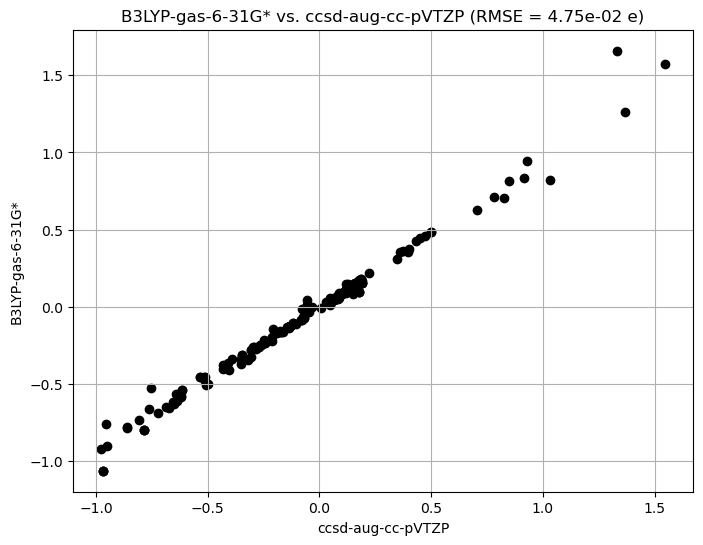

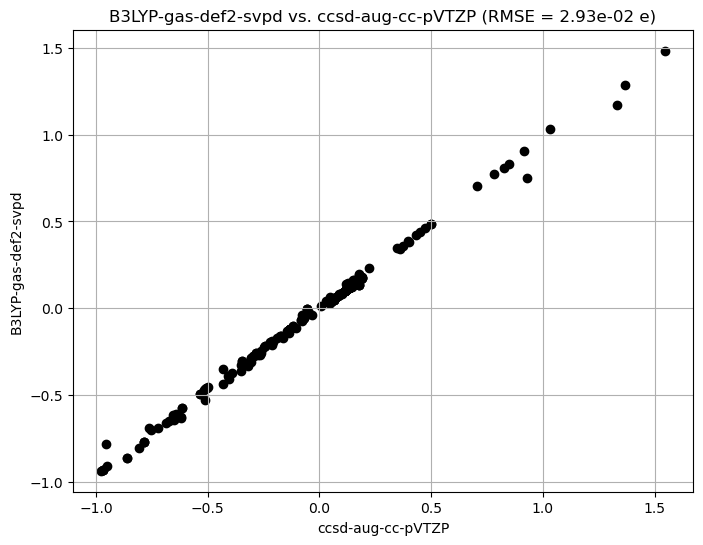

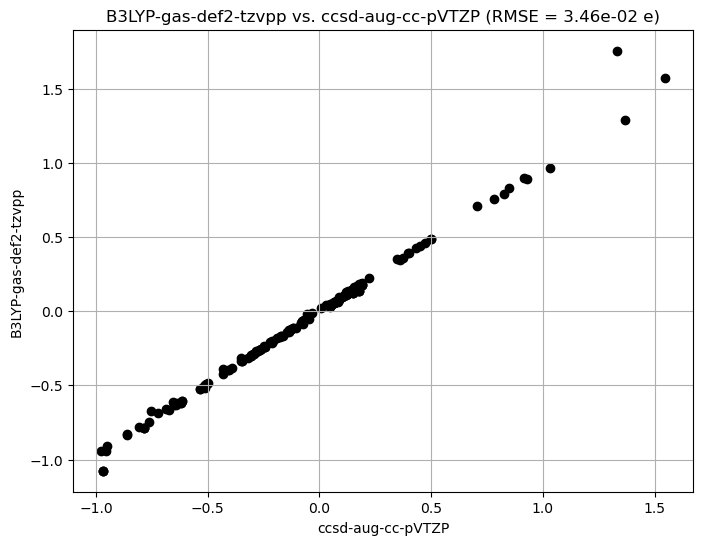

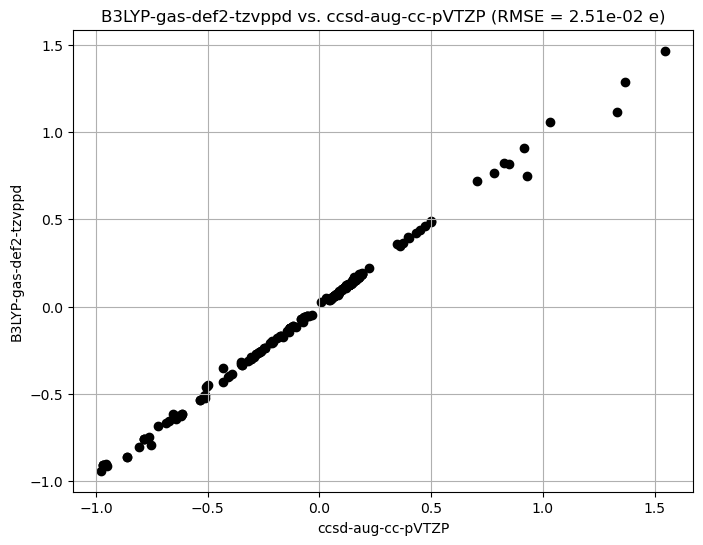

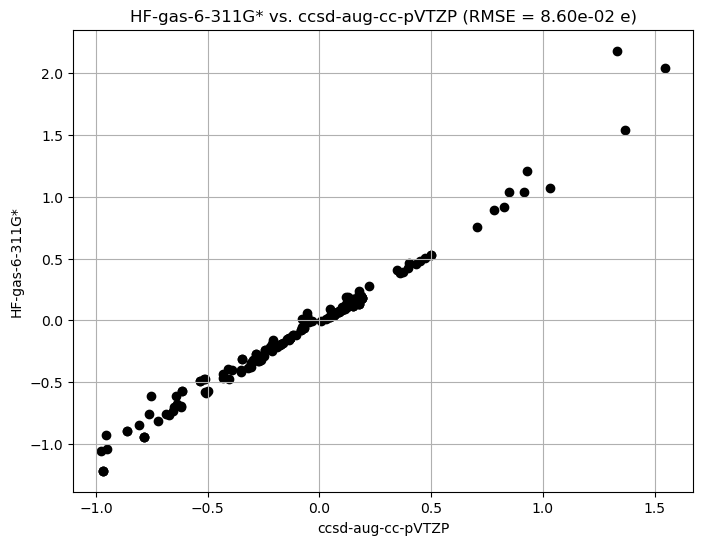

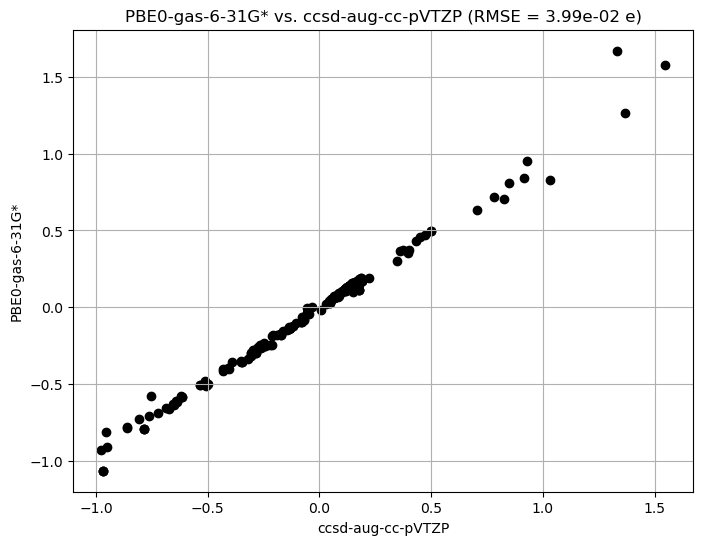

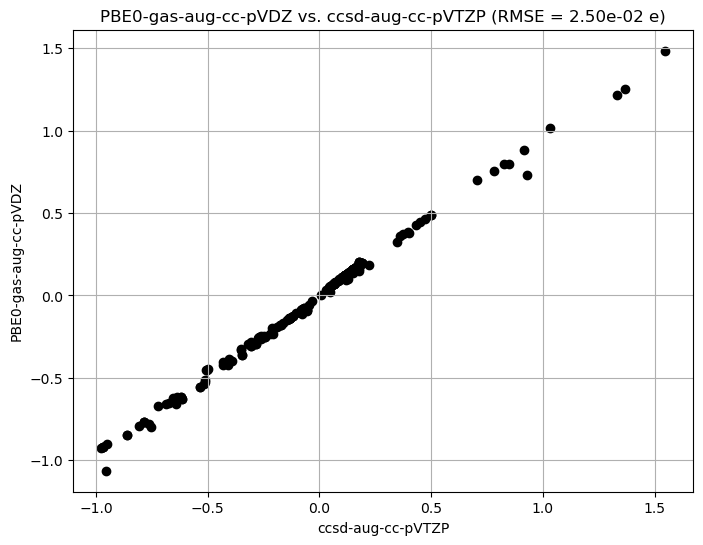

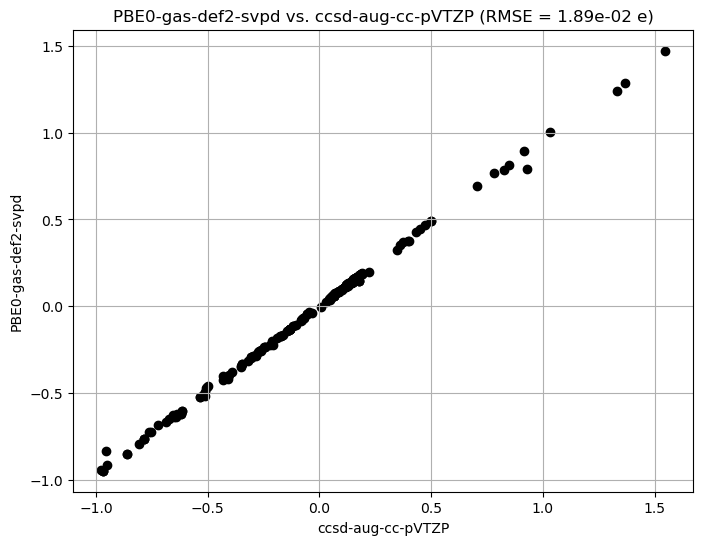

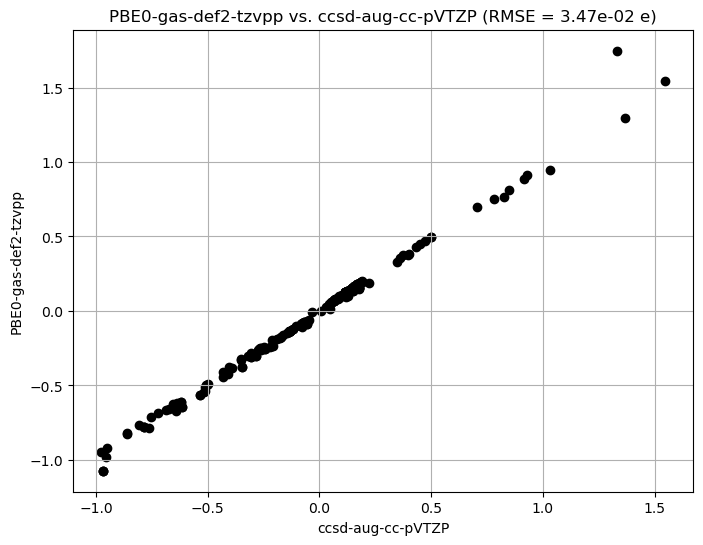

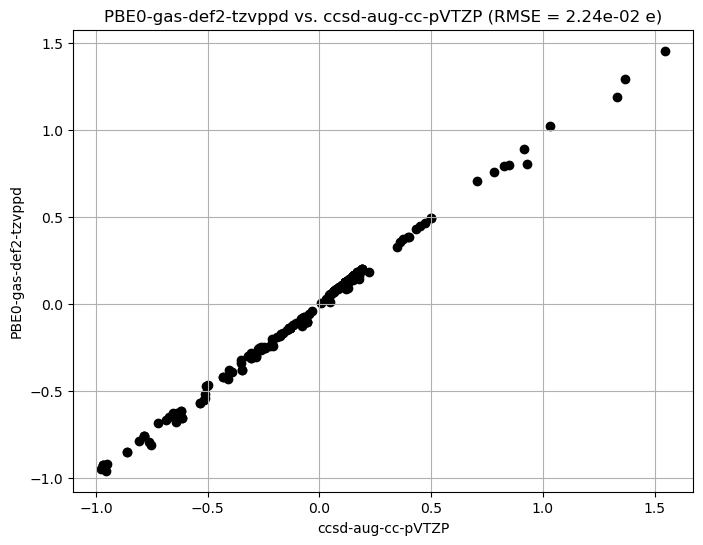

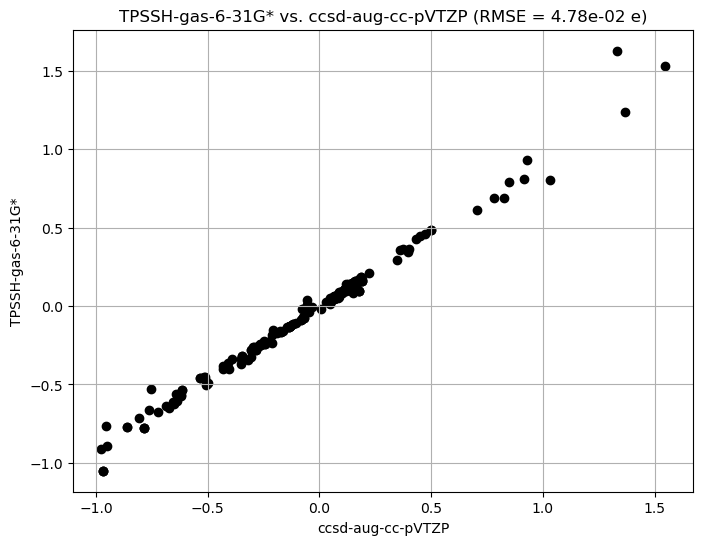

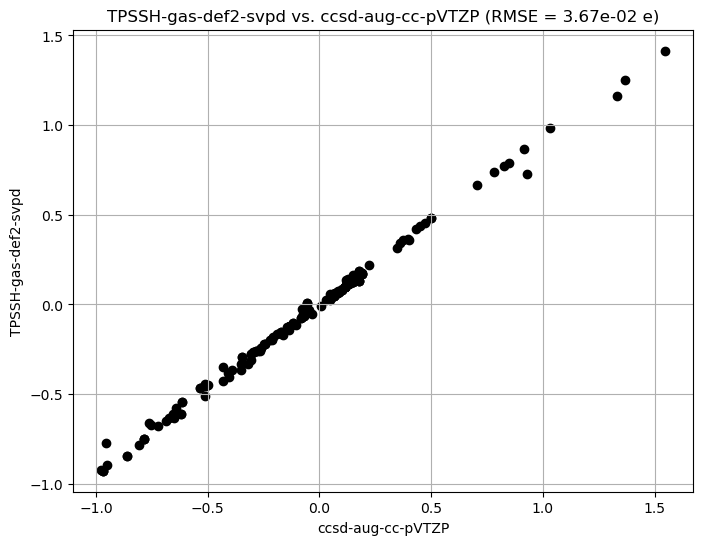

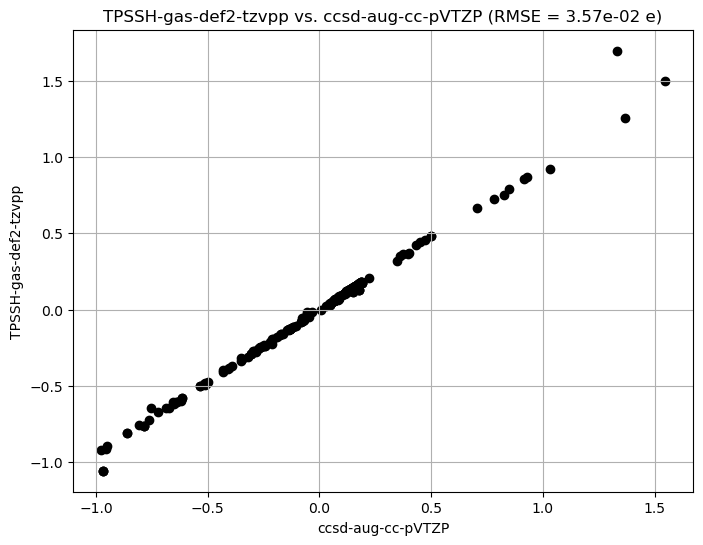

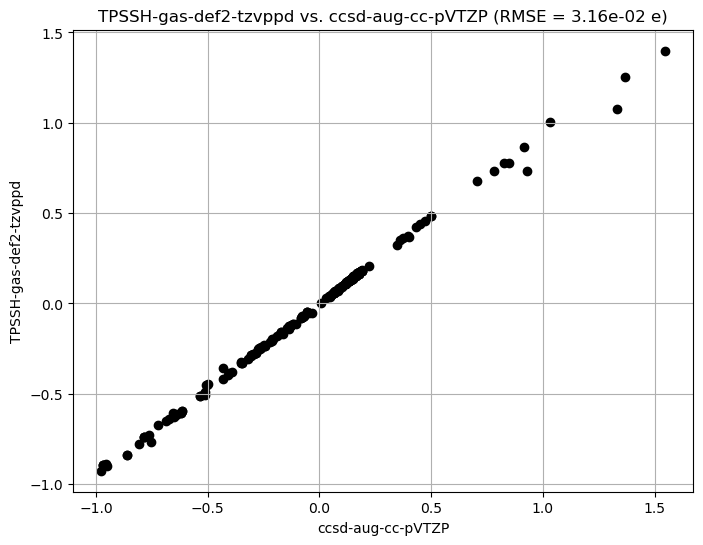

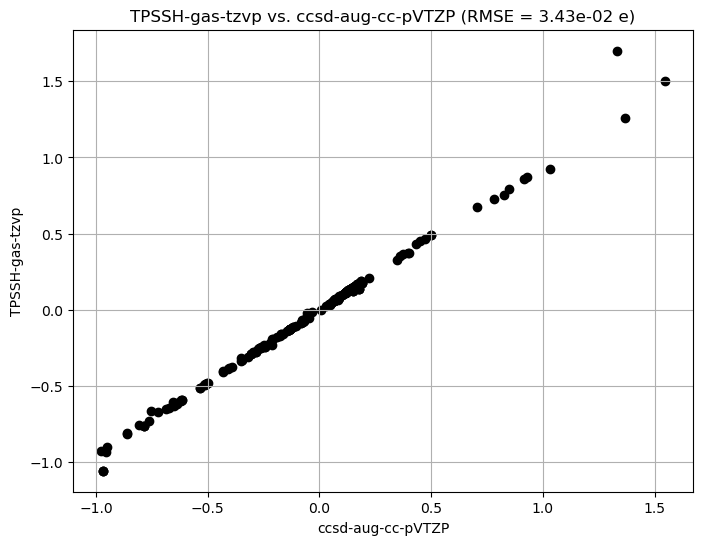

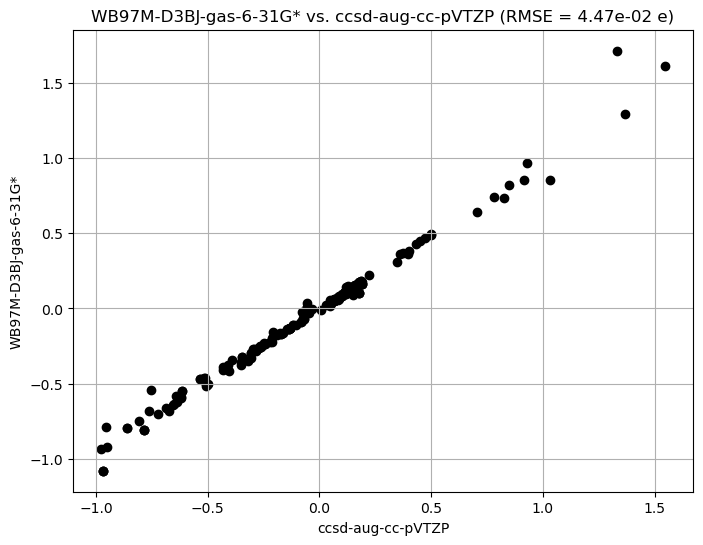

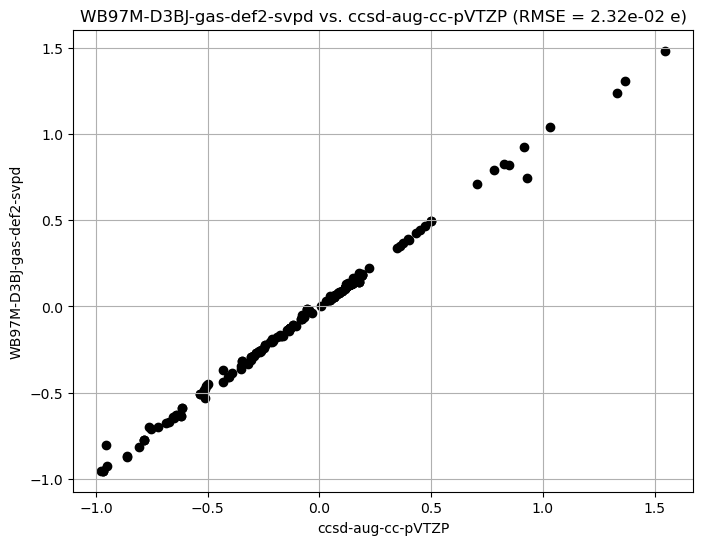

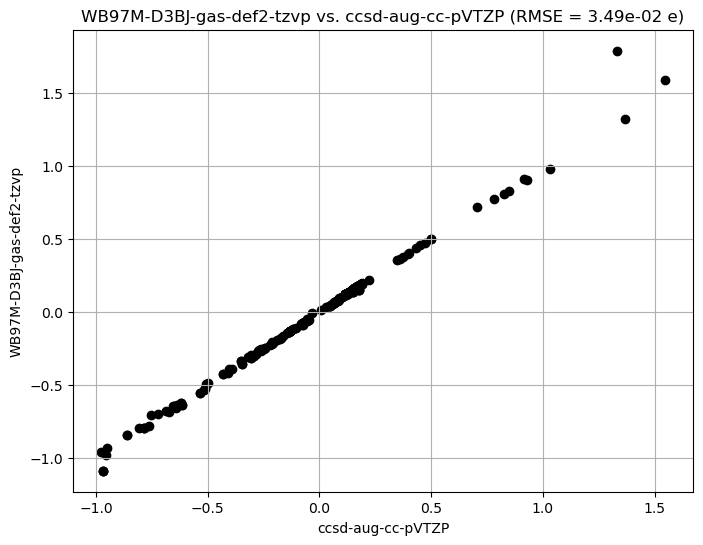

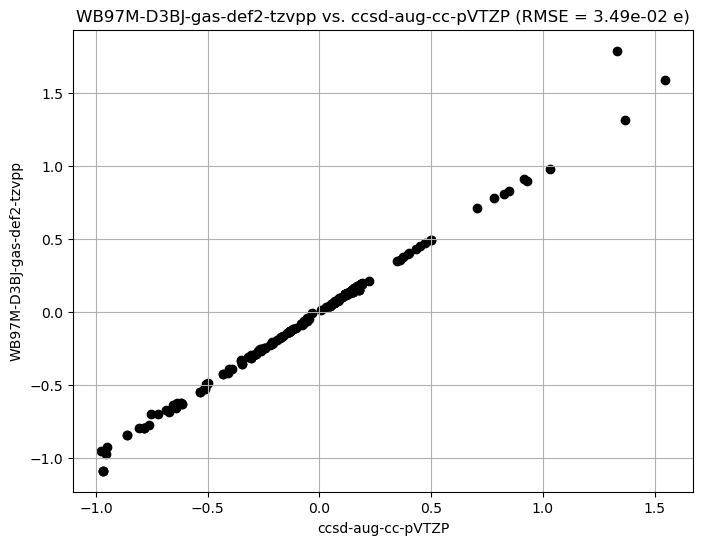

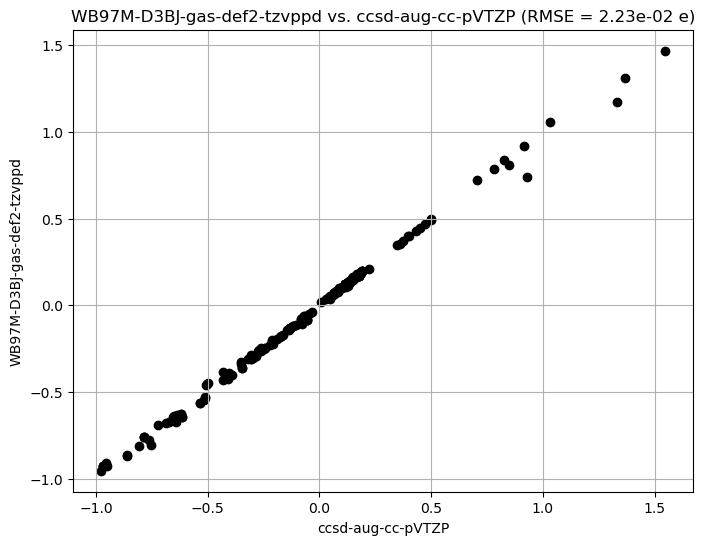

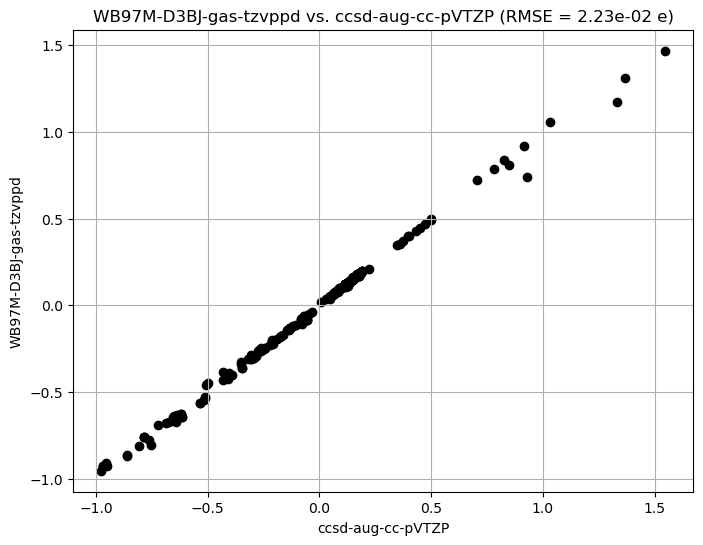

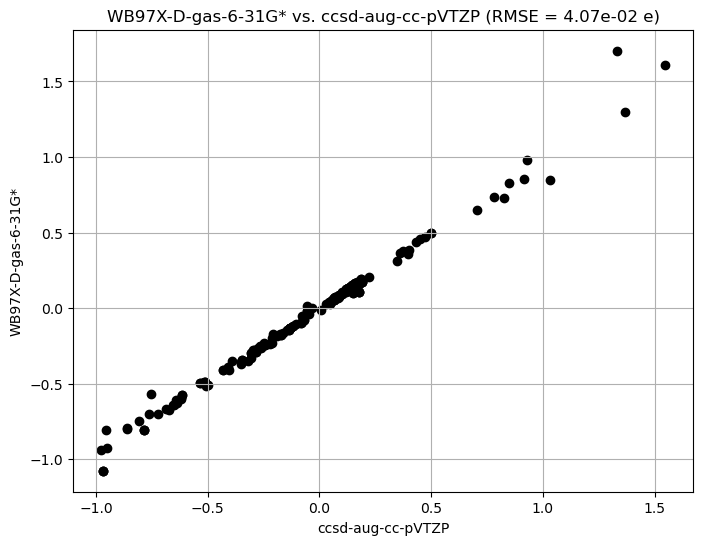

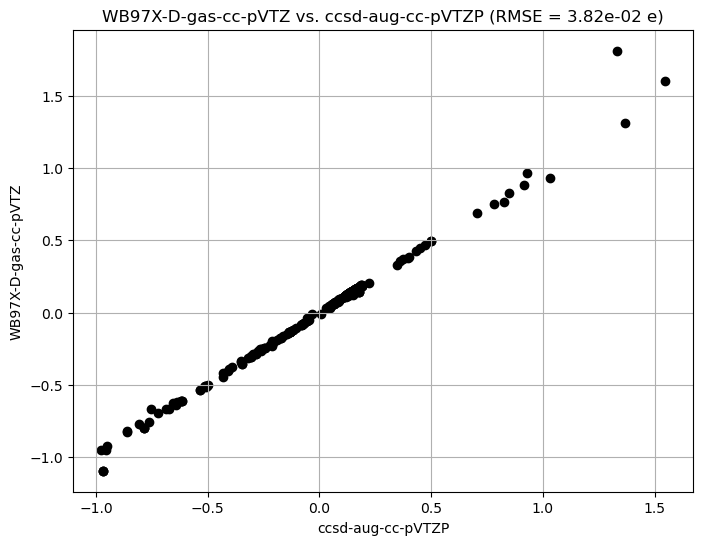

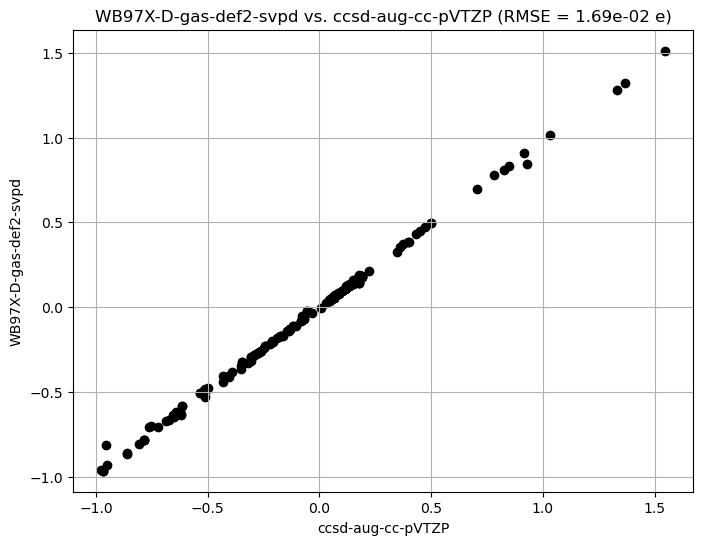

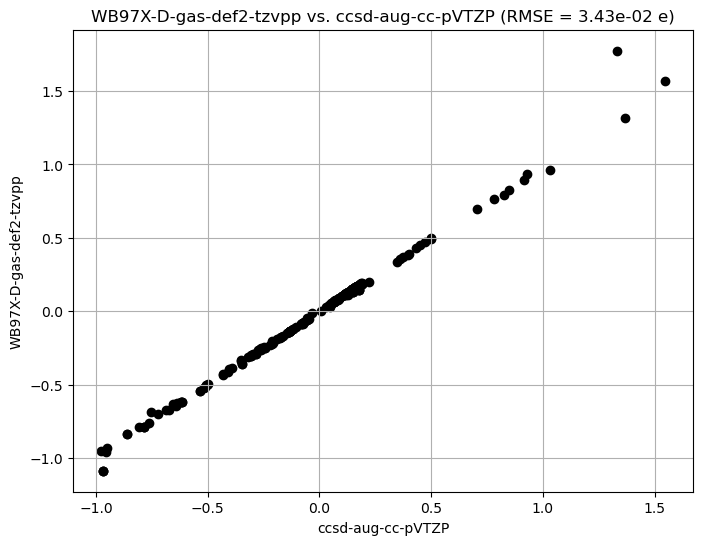

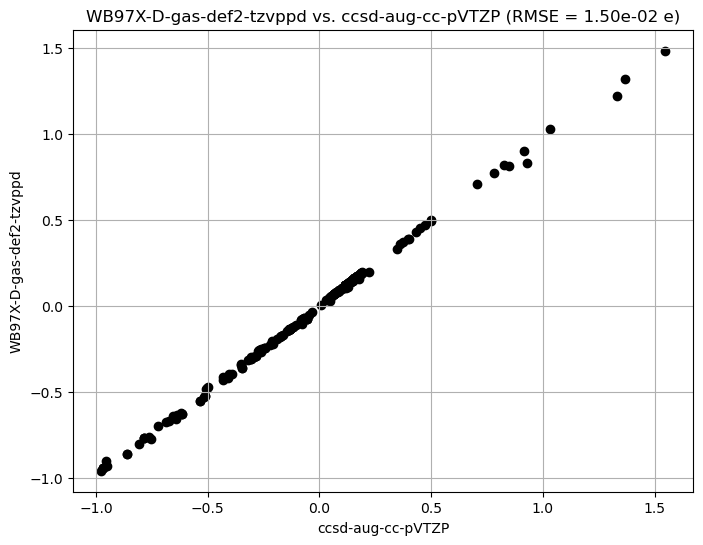

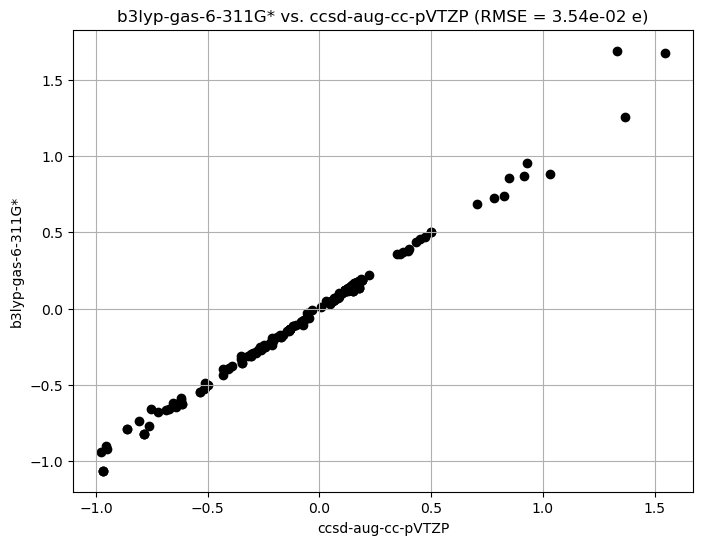

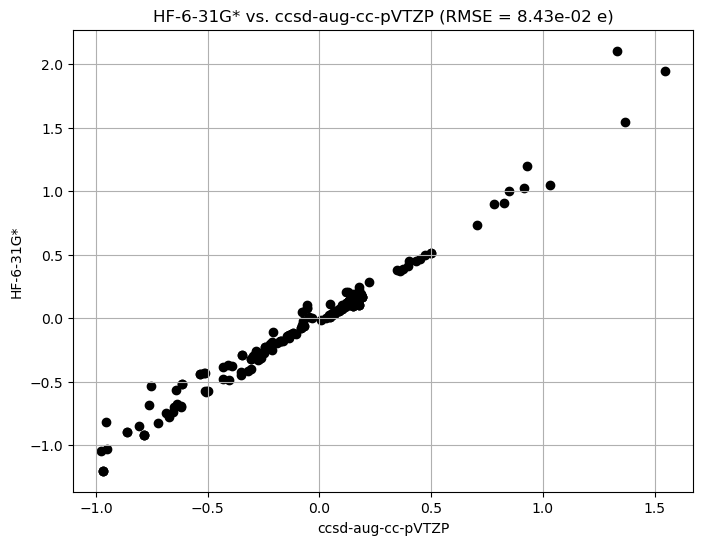

In [47]:
from sklearn.metrics import mean_squared_error

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
columns_to_plot = [col for col in pivot_df.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot.append('HF-6-31G*')
print(columns_to_plot)

remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

print(columns_to_plot)
# The target column for comparison
target_column = 'ccsd-aug-cc-pVTZP'

rmses = []
# df_rmse = pd.DataFrame(['spec','rmse'])
# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
molecule_rmses = []
for col in columns_to_plot:
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    clean_df = pivot_df[[target_column, col, 'molecule']].dropna()
    pivot_df_filter = pivot_df.filter(items = [target_column, col])
    pivot_df_wall_time_filter = pivot_df_wall_time.filter(items = [col])
    col_x = target_column
    x_tot = []
    y_tot = []
    w_time_tot = []
    for (index, row), (index_wt, row_wt) in zip(pivot_df_filter.iterrows(), pivot_df_wall_time_filter.iterrows()):
        x_values = row[col_x]
        if isinstance(x_values, np.ndarray):
                x_values = x_values.tolist()
                y_values = row[col]
                x_tot.extend(x_values)
                y_tot.extend(y_values)
                if 'ccsd' not in col:
                  w_time_tot.append(row_wt[col])
                # Check if y_values is a list and has the same length as x_values
                if isinstance(y_values, list) and len(x_values) == len(y_values):
                    plt.scatter(x_values, y_values, color='black')  # Use the color assigned to this column
                    rmse_molecule = np.sqrt(mean_squared_error(y_values, x_values))
                    information_molecule = {"molecule":clean_df['molecule'][index],
                                "spec": spec,
                                "rmse": rmse_molecule
                                }
                    molecule_rmses.append(information_molecule)
    # print(len(x_tot))
    if len(x_tot) == 0:
         continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    wall_tm_mean = np.mean(w_time_tot)
    information = {"rmse": rmse,
                   "spec": col,
                   "wall time": wall_tm_mean}
    

    rmses.append(information)

    plt.title(f'{col} vs. {target_column} (RMSE = {rmse:.2e} e)')        
    plt.xlabel(target_column)
    plt.ylabel(col)
    # Plotting details
    plt.grid(True)  # Optional: Add a grid for better readability
    plt.show()
df_dft_rmse = pandas.DataFrame(rmses)
df_molecules_rmse  = pandas.DataFrame(molecule_rmses)



In [48]:
df_dft_rmse

rmse                        spec  wall time
0   0.047499            B3LYP-gas-6-31G*  15.208631
1   0.029292         B3LYP-gas-def2-svpd  19.834959
2   0.034560        B3LYP-gas-def2-tzvpp  37.428640
3   0.025056       B3LYP-gas-def2-tzvppd  23.095714
4   0.086019              HF-gas-6-311G*   7.488843
5   0.039932             PBE0-gas-6-31G*  14.916173
6   0.024952        PBE0-gas-aug-cc-pVDZ  12.183749
7   0.018935          PBE0-gas-def2-svpd  24.174800
8   0.034658         PBE0-gas-def2-tzvpp  23.499730
9   0.022404        PBE0-gas-def2-tzvppd  23.165761
10  0.047829            TPSSH-gas-6-31G*  20.106914
11  0.036737         TPSSH-gas-def2-svpd  39.977291
12  0.035667        TPSSH-gas-def2-tzvpp  40.363557
13  0.031630       TPSSH-gas-def2-tzvppd  34.317174
14  0.034294              TPSSH-gas-tzvp  14.918995
15  0.044721       WB97M-D3BJ-gas-6-31G*  20.531966
16  0.023162    WB97M-D3BJ-gas-def2-svpd  27.555052
17  0.034937    WB97M-D3BJ-gas-def2-tzvp  19.551742
18  0.034928   WB97M-D3BJ-gas-def2-tzvpp  76.164997
19  0.022275  WB97M-D3BJ-gas-def2-tzvppd  48.824292
20  0.022276       WB97M-D3BJ-gas-tzvppd  29.194443
21  0.040710          WB97X-D-gas-6-31G*  15.737583
22  0.038206         WB97X-D-gas-cc-pVTZ  81.550179
23  0.016942       WB97X-D-gas-def2-svpd  27.546294
24  0.034341      WB97X-D-gas-def2-tzvpp  25.266936
25  0.015011     WB97X-D-gas-def2-tzvppd  24.777859
26  0.035432           b3lyp-gas-6-311G*   8.979888
27  0.084301                   HF-6-31G*  11.691606

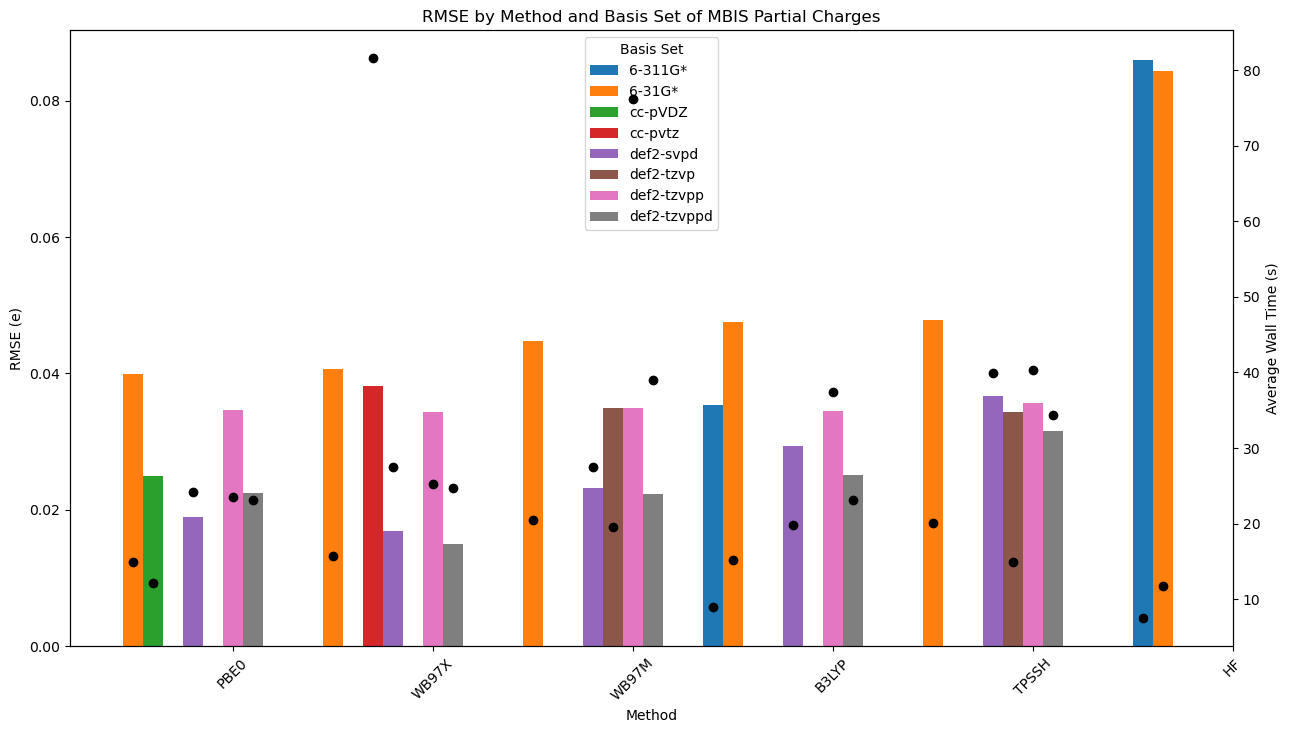

In [49]:
# Create a DataFrame from the list
df_rmse = df_dft_rmse


# Extract method and basis from the 'spec' key
df_rmse['method'] = df_rmse['spec'].apply(lambda x: x.split('-')[0].upper())  # Convert method to uppercase for consistency
df_rmse['basis'] = df_rmse['spec'].apply(lambda x: '-'.join(x.split('-')[-2:]))

# Calculate average RMSE for each method to determine the order
average_rmse_by_method = df_rmse.groupby('method')['rmse'].mean().sort_values()

# Sort the dataframe by the average RMSE of each method
df_rmse['method_avg_rmse'] = df_rmse['method'].map(average_rmse_by_method)
df_rmse_sorted = df_rmse.sort_values(by=['method_avg_rmse', 'method', 'basis'])
df_rmse_sorted.drop('method_avg_rmse', axis=1, inplace=True)
# Use a categorical type to ensure the methods are plotted in the sorted order
df_rmse_sorted['method'] = pd.Categorical(df_rmse_sorted['method'], categories=average_rmse_by_method.index, ordered=True)

# Normalize basis set labels
df_rmse_sorted['basis'] = df_rmse_sorted['basis'].replace({
    'cc-pVTZ': 'cc-pvtz',
    'gas-tzvp': 'def2-tzvp',
    'gas-tzvppd': 'def2-tzvppd'
})


# Creating a color map
unique_basis = df_rmse_sorted['basis'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_basis)))
color_map = dict(zip(unique_basis, colors))

# Creating the pivot table
pivot_table = df_rmse_sorted.pivot_table(index='method', columns='basis', values='rmse', aggfunc = 'mean')
pivot_table_wall = df_rmse_sorted.pivot_table(index='method', columns='basis', values='wall time', aggfunc = 'mean')

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.1  # Adjust as necessary for the number of basis sets
group_width = np.max([np.sum(~pivot_table.loc[method].isna()) for method in pivot_table.index]) * bar_width
ax2 = ax.twinx()

# Now, for each basis, we will calculate the exact position
for i, basis in enumerate(pivot_table.columns):
    # Create an offset array which positions each bar in the center of its group
    offsets = np.array([bar_width * (i - np.sum(~pivot_table.loc[method].isna())/2) for method in pivot_table.index])
    # Calculate the actual positions for each bar
    positions = np.arange(len(pivot_table.index)) + offsets
    # Plot the bars
    ax.bar(positions, pivot_table[basis], width=bar_width, label=basis)
    ax2.scatter(positions, pivot_table_wall[basis],  label=basis, color = 'black')



# Set the position of the x-axis ticks and labels
ax.set_xticks(np.arange(len(pivot_table)) + bar_width / 2 * (len(pivot_table.columns) - 1))
ax.set_xticklabels(pivot_table.index, rotation=45)

# Adding labels and legend
ax.set_xlabel('Method')
ax.set_ylabel('RMSE (e)')
ax2.set_ylabel('Average Wall Time (s)')
ax.set_title('RMSE by Method and Basis Set of MBIS Partial Charges')
ax.legend(title='Basis Set')

plt.show()

In [50]:
df_rmse

rmse                        spec  wall time method        basis  \
0   0.047499            B3LYP-gas-6-31G*  15.208631  B3LYP       6-31G*   
1   0.029292         B3LYP-gas-def2-svpd  19.834959  B3LYP    def2-svpd   
2   0.034560        B3LYP-gas-def2-tzvpp  37.428640  B3LYP   def2-tzvpp   
3   0.025056       B3LYP-gas-def2-tzvppd  23.095714  B3LYP  def2-tzvppd   
4   0.086019              HF-gas-6-311G*   7.488843     HF      6-311G*   
5   0.039932             PBE0-gas-6-31G*  14.916173   PBE0       6-31G*   
6   0.024952        PBE0-gas-aug-cc-pVDZ  12.183749   PBE0      cc-pVDZ   
7   0.018935          PBE0-gas-def2-svpd  24.174800   PBE0    def2-svpd   
8   0.034658         PBE0-gas-def2-tzvpp  23.499730   PBE0   def2-tzvpp   
9   0.022404        PBE0-gas-def2-tzvppd  23.165761   PBE0  def2-tzvppd   
10  0.047829            TPSSH-gas-6-31G*  20.106914  TPSSH       6-31G*   
11  0.036737         TPSSH-gas-def2-svpd  39.977291  TPSSH    def2-svpd   
12  0.035667        TPSSH-gas-def2-tzvpp  40.363557  TPSSH   def2-tzvpp   
13  0.031630       TPSSH-gas-def2-tzvppd  34.317174  TPSSH  def2-tzvppd   
14  0.034294              TPSSH-gas-tzvp  14.918995  TPSSH     gas-tzvp   
15  0.044721       WB97M-D3BJ-gas-6-31G*  20.531966  WB97M       6-31G*   
16  0.023162    WB97M-D3BJ-gas-def2-svpd  27.555052  WB97M    def2-svpd   
17  0.034937    WB97M-D3BJ-gas-def2-tzvp  19.551742  WB97M    def2-tzvp   
18  0.034928   WB97M-D3BJ-gas-def2-tzvpp  76.164997  WB97M   def2-tzvpp   
19  0.022275  WB97M-D3BJ-gas-def2-tzvppd  48.824292  WB97M  def2-tzvppd   
20  0.022276       WB97M-D3BJ-gas-tzvppd  29.194443  WB97M   gas-tzvppd   
21  0.040710          WB97X-D-gas-6-31G*  15.737583  WB97X       6-31G*   
22  0.038206         WB97X-D-gas-cc-pVTZ  81.550179  WB97X      cc-pVTZ   
23  0.016942       WB97X-D-gas-def2-svpd  27.546294  WB97X    def2-svpd   
24  0.034341      WB97X-D-gas-def2-tzvpp  25.266936  WB97X   def2-tzvpp   
25  0.015011     WB97X-D-gas-def2-tzvppd  24.777859  WB97X  def2-tzvppd   
26  0.035432           b3lyp-gas-6-311G*   8.979888  B3LYP      6-311G*   
27  0.084301                   HF-6-31G*  11.691606     HF       6-31G*   

    method_avg_rmse  
0          0.034368  
1          0.034368  
2          0.034368  
3          0.034368  
4          0.085160  
5          0.028176  
6          0.028176  
7          0.028176  
8          0.028176  
9          0.028176  
10         0.037231  
11         0.037231  
12         0.037231  
13         0.037231  
14         0.037231  
15         0.030383  
16         0.030383  
17         0.030383  
18         0.030383  
19         0.030383  
20         0.030383  
21         0.029042  
22         0.029042  
23         0.029042  
24         0.029042  
25         0.029042  
26         0.034368  
27         0.085160

In [51]:
df_rmse_sorted

rmse                        spec  wall time method        basis
5   0.039932             PBE0-gas-6-31G*  14.916173   PBE0       6-31G*
6   0.024952        PBE0-gas-aug-cc-pVDZ  12.183749   PBE0      cc-pVDZ
7   0.018935          PBE0-gas-def2-svpd  24.174800   PBE0    def2-svpd
8   0.034658         PBE0-gas-def2-tzvpp  23.499730   PBE0   def2-tzvpp
9   0.022404        PBE0-gas-def2-tzvppd  23.165761   PBE0  def2-tzvppd
21  0.040710          WB97X-D-gas-6-31G*  15.737583  WB97X       6-31G*
22  0.038206         WB97X-D-gas-cc-pVTZ  81.550179  WB97X      cc-pvtz
23  0.016942       WB97X-D-gas-def2-svpd  27.546294  WB97X    def2-svpd
24  0.034341      WB97X-D-gas-def2-tzvpp  25.266936  WB97X   def2-tzvpp
25  0.015011     WB97X-D-gas-def2-tzvppd  24.777859  WB97X  def2-tzvppd
15  0.044721       WB97M-D3BJ-gas-6-31G*  20.531966  WB97M       6-31G*
16  0.023162    WB97M-D3BJ-gas-def2-svpd  27.555052  WB97M    def2-svpd
17  0.034937    WB97M-D3BJ-gas-def2-tzvp  19.551742  WB97M    def2-tzvp
18  0.034928   WB97M-D3BJ-gas-def2-tzvpp  76.164997  WB97M   def2-tzvpp
19  0.022275  WB97M-D3BJ-gas-def2-tzvppd  48.824292  WB97M  def2-tzvppd
20  0.022276       WB97M-D3BJ-gas-tzvppd  29.194443  WB97M  def2-tzvppd
26  0.035432           b3lyp-gas-6-311G*   8.979888  B3LYP      6-311G*
0   0.047499            B3LYP-gas-6-31G*  15.208631  B3LYP       6-31G*
1   0.029292         B3LYP-gas-def2-svpd  19.834959  B3LYP    def2-svpd
2   0.034560        B3LYP-gas-def2-tzvpp  37.428640  B3LYP   def2-tzvpp
3   0.025056       B3LYP-gas-def2-tzvppd  23.095714  B3LYP  def2-tzvppd
10  0.047829            TPSSH-gas-6-31G*  20.106914  TPSSH       6-31G*
11  0.036737         TPSSH-gas-def2-svpd  39.977291  TPSSH    def2-svpd
12  0.035667        TPSSH-gas-def2-tzvpp  40.363557  TPSSH   def2-tzvpp
13  0.031630       TPSSH-gas-def2-tzvppd  34.317174  TPSSH  def2-tzvppd
14  0.034294              TPSSH-gas-tzvp  14.918995  TPSSH    def2-tzvp
4   0.086019              HF-gas-6-311G*   7.488843     HF      6-311G*
27  0.084301                   HF-6-31G*  11.691606     HF       6-31G*

In [52]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df_dipole = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='dipole',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()
pivot_df_dipole

specification           molecule  \
0                     B(O)(O)OCC   
1                    C1=CNC=C1Br   
2                      C1=CSC=C1   
3                  C1=CSN=C1[O-]   
4                  C1=C[NH+]=CN1   
5                    C1CC(=O)NC1   
6                        C1CCNC1   
7                        C1CCOC1   
8                  C1CC[NH2+]CC1   
9                             CC   
10                       CC(=O)C   
11                       CC(=O)O   
12                    CC(=O)[O-]   
13                        CC(C)F   
14               CC1=CNc2c1cccc2   
15                           CCO   
16                           CCS   
17                          CCSC   
18                           COC   
19                   COCC(F)(F)F   
20                 CO[Si](C)(C)O   
21              CP(=O)([O-])[O-]   
22                CS(=O)(=O)[O-]   
23                C[Si]1(CCCC1)C   
24              [B-](COC)(F)(F)F   
25             c1cc(c(c(c1)F)F)F   
26                  c1cc(cnc1)Cl   
27                  c1ccc(cc1)Br   
28                 c1ccc(cc1)C#N   
29                  c1ccc(cc1)Cl   
30                   c1ccc(cc1)F   
31                   c1ccc(cc1)I   
32                   c1ccc(cc1)N   
33                   c1ccc(cc1)O   
34                c1ccc(cc1)[S-]   
35                      c1ccccc1   

specification                              B3LYP-ddx-4-def2-svpd  \
0              [-0.19012242440761895, -0.0073349076296178595,...   
1              [-1.4534097834241209, -0.7222612025170356, -0....   
2              [-0.001628414685781454, -0.27891985036941236, ...   
3              [3.305862364148382, -0.8558372315690619, -0.20...   
4              [-0.35124872858221634, -0.5886168760343935, 0....   
5              [-1.6732229180965277, 1.0007582490235833, 0.21...   
6              [0.5427013697964007, 0.07985423271158965, -0.2...   
7              [-0.03134308388610174, -0.831325695538947, 0.0...   
8              [-0.2528306559705289, 1.7510305561032444, -0.2...   
9              [3.8007376579329843e-07, 2.3077558441997326e-0...   
10             [-0.05324808863394326, 1.0718632614229762, 0.9...   
11             [-0.2218885194824054, -0.5728920932264909, 0.5...   
12             [-2.9553523334410556, -0.4917083112870042, -0....   
13             [0.01990796684564966, 0.6895523117991438, 0.54...   
14             [-0.45605638918278757, 0.8428570658358936, 0.0...   
15             [-0.49141562663321103, 0.1972690165222919, -0....   
16             [-0.577832150822708, 0.23280426580435432, -0.5...   
17             [-0.2553482323987524, -0.19252979314075258, -0...   
18             [0.01710777288339793, -0.5799609282342608, 0.0...   
19             [-0.9003393708358232, -0.5309642085934954, -0....   
20             [0.29252987443727463, 0.3292004714069554, 0.57...   
21             [-4.842461130049415, -0.09193991220752062, -0....   
22             [3.255743040381901, 0.0385256710519466, 0.0427...   
23             [0.057280484143358734, -0.004338692189248317, ...   
24             [-2.6099837041172123, -0.6628549891551678, -0....   
25             [-1.0345637413225006, -0.7703187157233415, -0....   
26             [-0.5903030392137794, 0.799257523282698, -0.00...   
27             [-0.7750215473203355, 0.382825564921248, 0.053...   
28             [-2.013923407191072, -0.30030686935766315, -0....   
29             [-0.7319102727703211, 0.46032999475503544, 0.0...   
30             [0.4601089770419762, 0.49350440313399346, -0.0...   
31             [-0.7862148869598684, 0.04115424705968529, 0.0...   
32             [0.8712170900988192, 0.025575183633600673, -0....   
33             [-0.18087423160459437, 0.023013588568377763, 0...   
34             [-4.4820626454777965, 2.549286216191291, 0.143...   
35             [8.71959444870285e-07, 3.5603453696353426e-07,...   

specification                             B3LYP-ddx-4-def2-tzvpp  \
0              [-0.15628327023001987, -0.022716245131489288, ...   
1             

ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz
['B3LYP-gas-6-31G*', 'B3LYP-gas-def2-svpd', 'B3LYP-gas-def2-tzvpp', 'B3LYP-gas-def2-tzvppd', 'HF-gas-6-311G*', 'PBE0-gas-6-31G*', 'PBE0-gas-aug-cc-pVDZ', 'PBE0-gas-def2-svpd', 'PBE0-gas-def2-tzvpp', 'PBE0-gas-def2-tzvppd', 'TPSSH-gas-6-31G*', 'TPSSH-gas-def2-svpd', 'TPSSH-gas-def2-tzvpp', 'TPSSH-gas-def2-tzvppd', 'TPSSH-gas-tzvp', 'WB97M-D3BJ-gas-6-31G*', 'WB97M-D3BJ-gas-def2-svpd', 'WB97M-D3BJ-gas-def2-tzvp', 'WB97M-D3BJ-gas-def2-tzvpp', 'WB97M-D3BJ-gas-def2-tzvppd', 'WB97M-D3BJ-gas-tzvppd', 'WB97X-D-gas-6-31G*', 'WB97X-D-gas-cc-pVTZ', 'WB97X-D-gas-def2-svpd', 'WB97X-D-gas-def2-tzvpp', 'WB97X-D-gas-def2-tzvppd', 'b3lyp-gas-6-311G*', 'HF-6-31G*']


/scratch/ipykernel_29814/4254970126.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df_dipole[columns_to_plot].applymap(normalize_dipole)


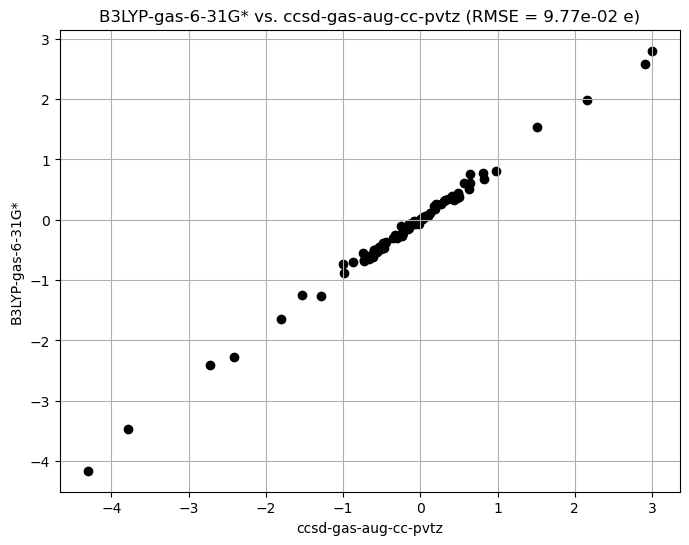

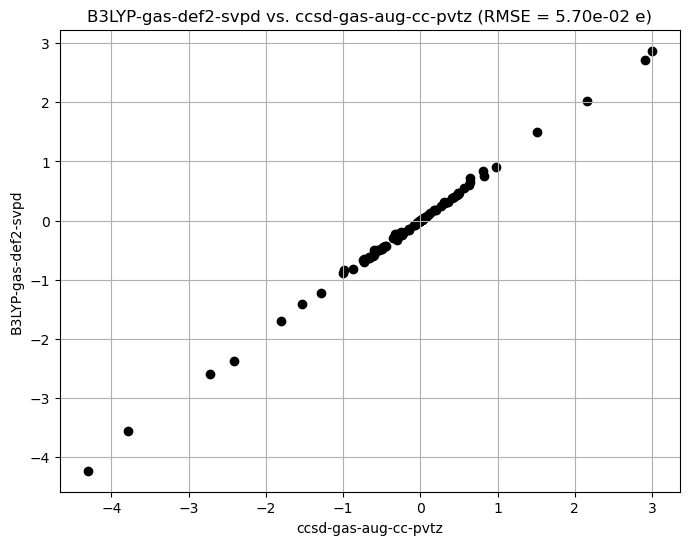

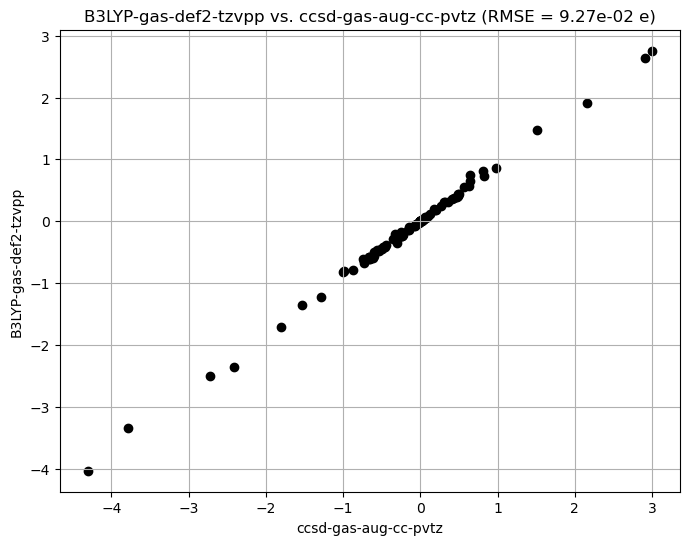

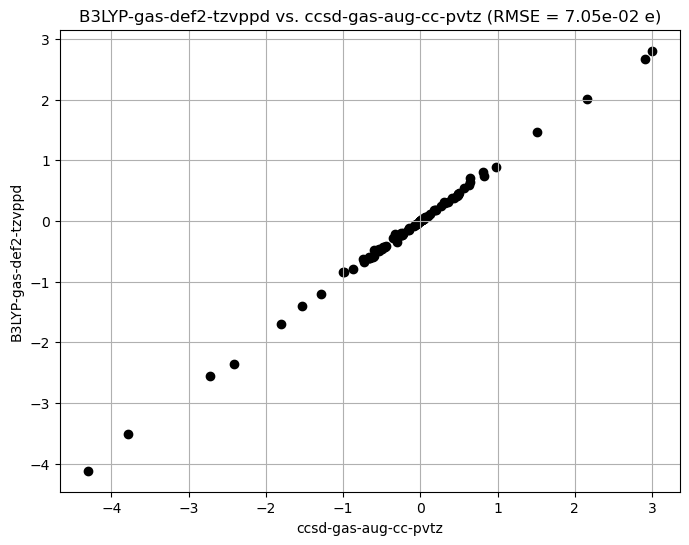

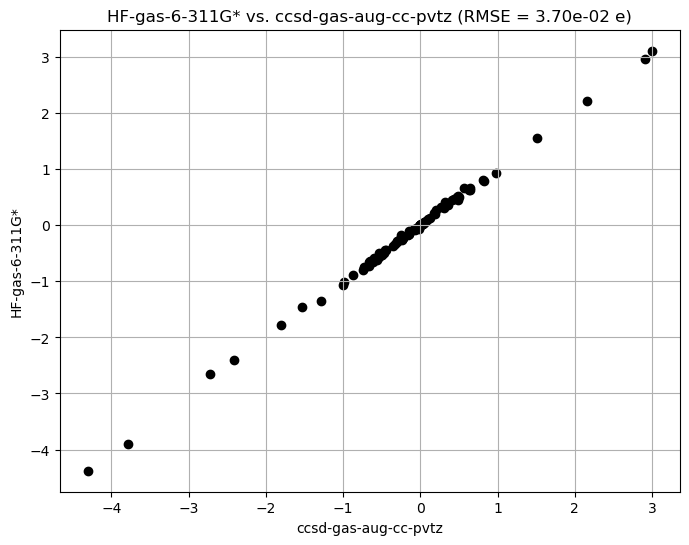

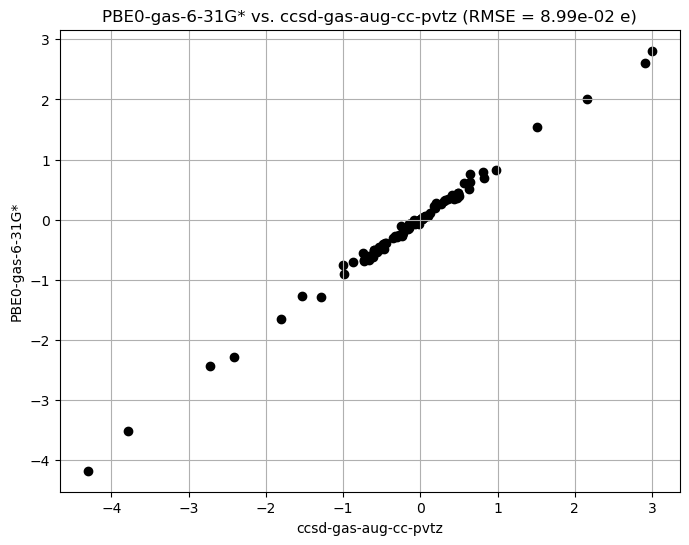

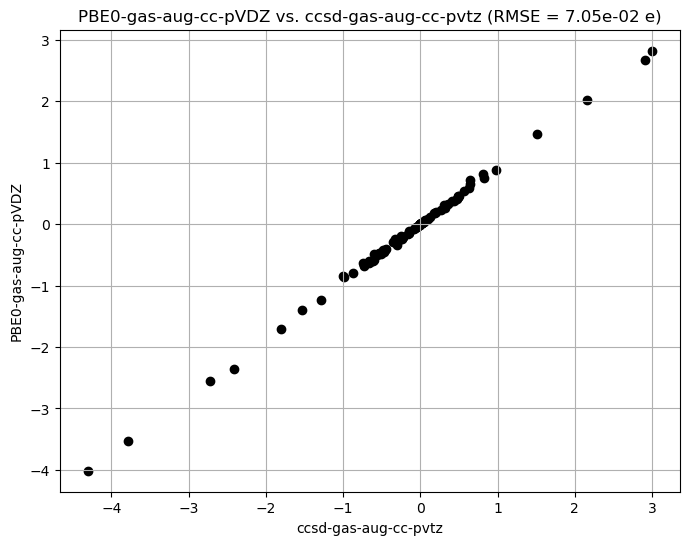

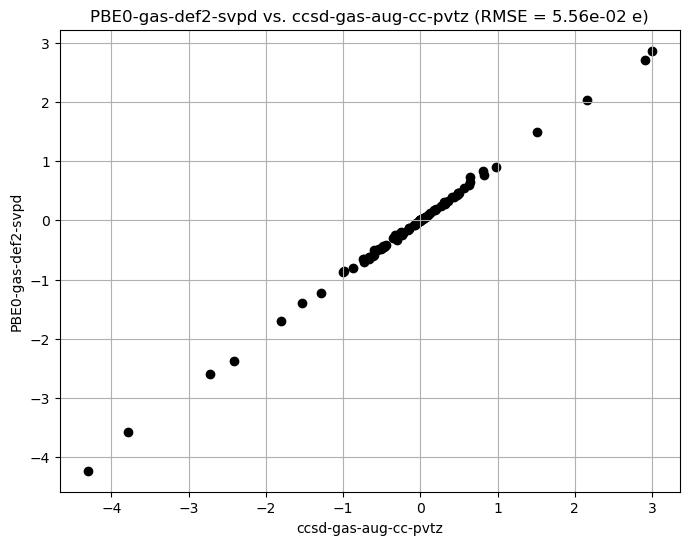

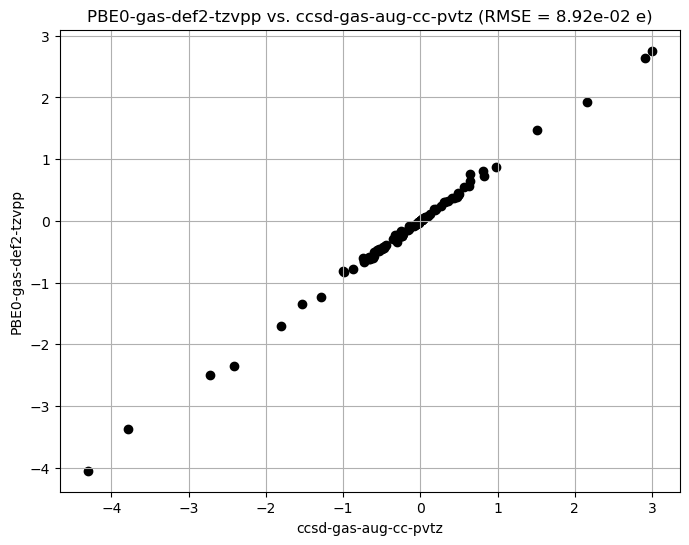

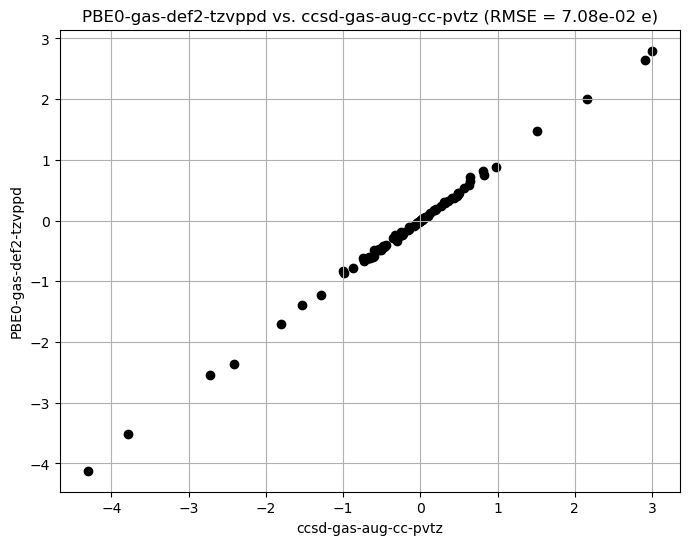

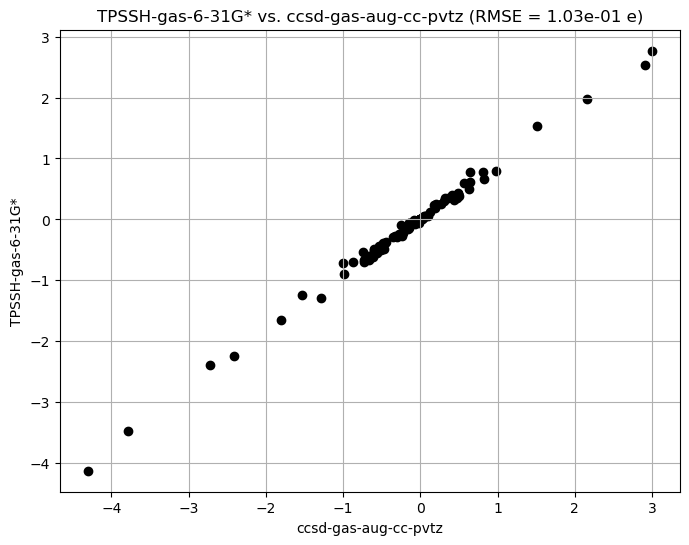

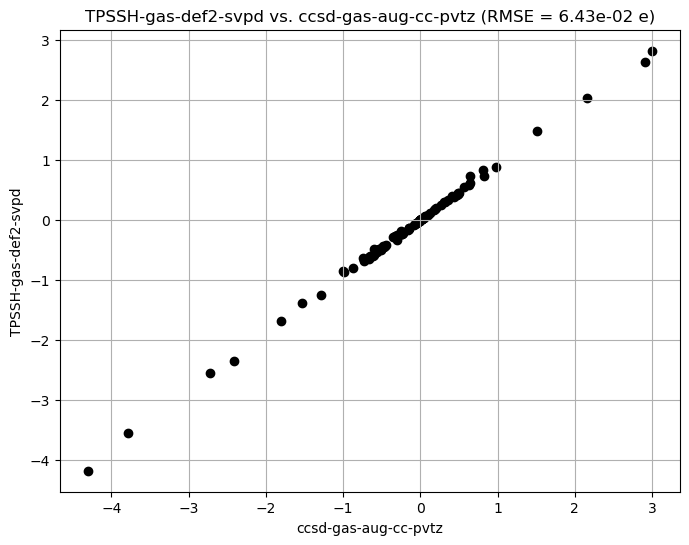

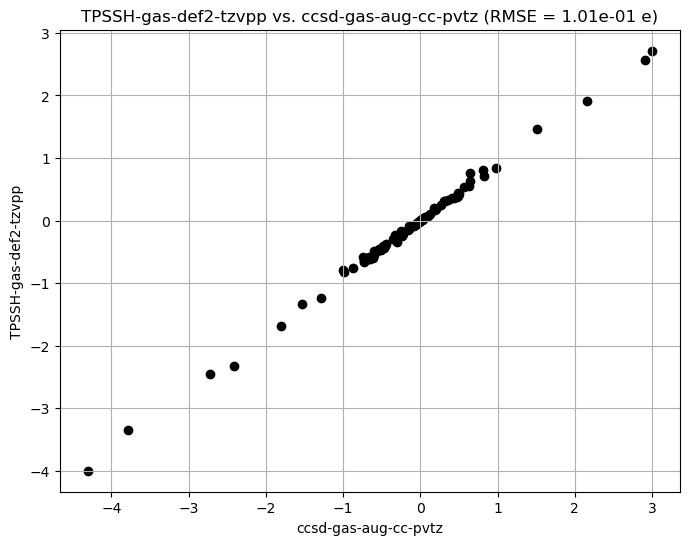

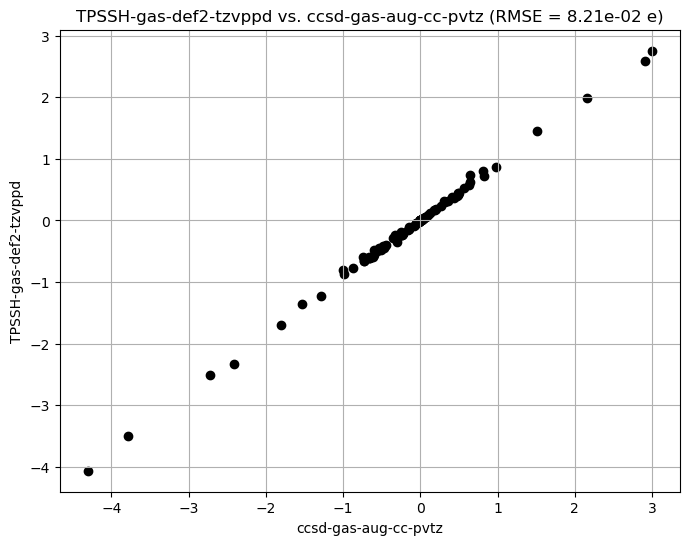

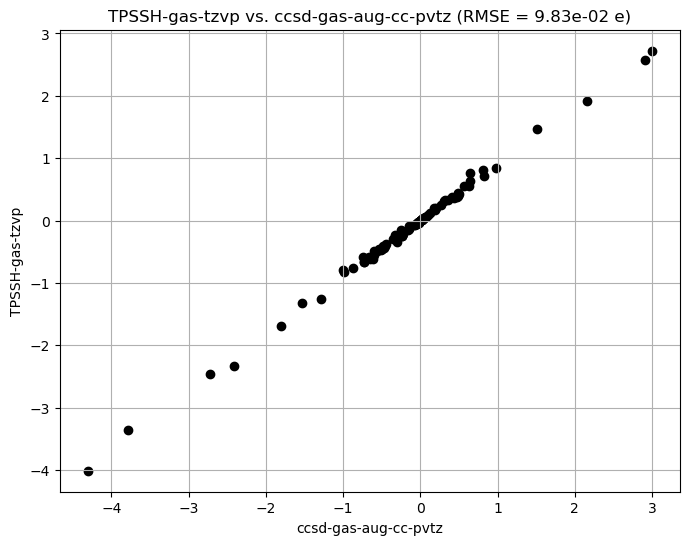

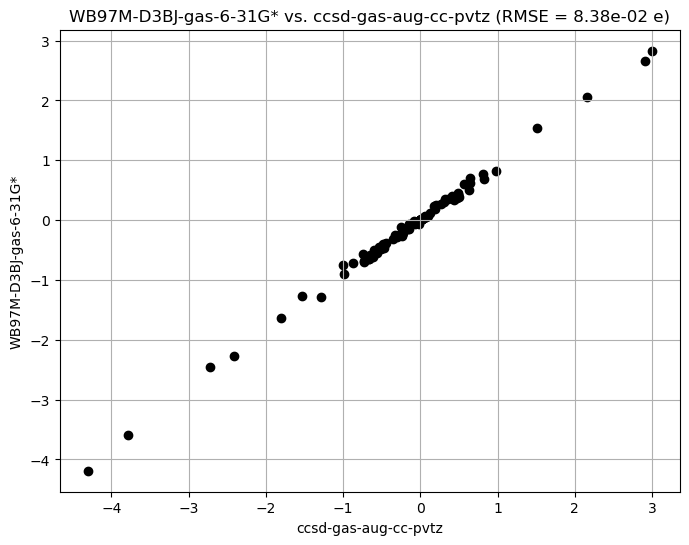

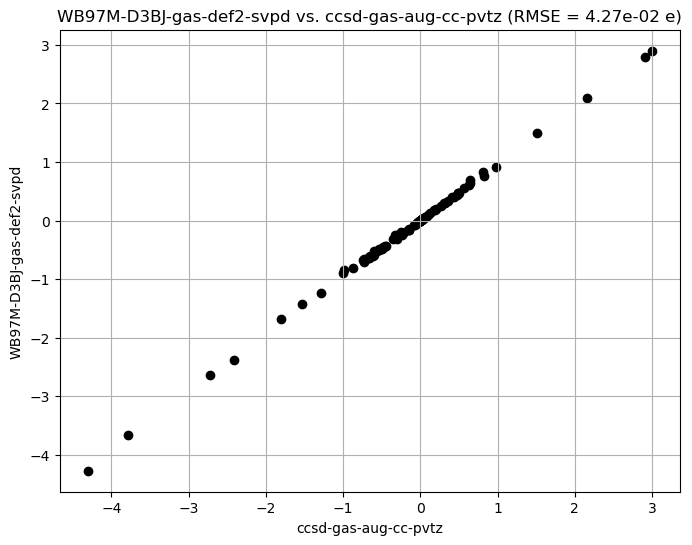

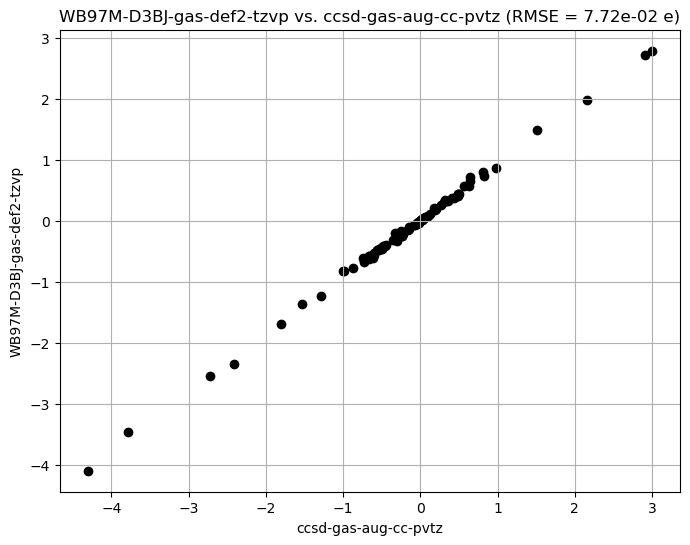

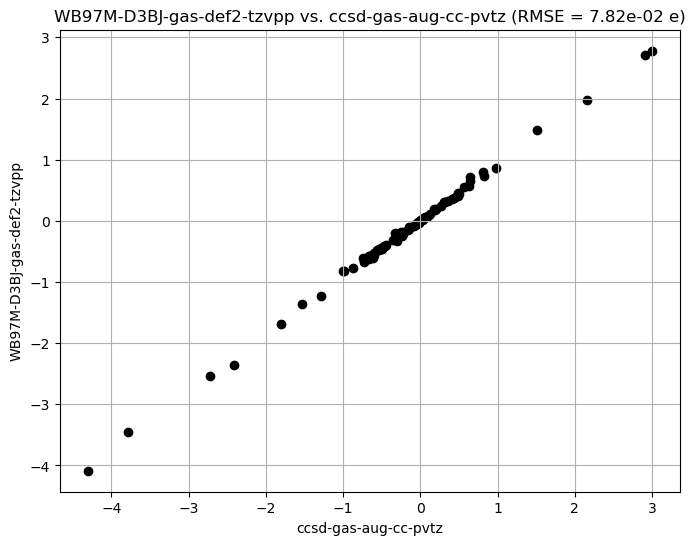

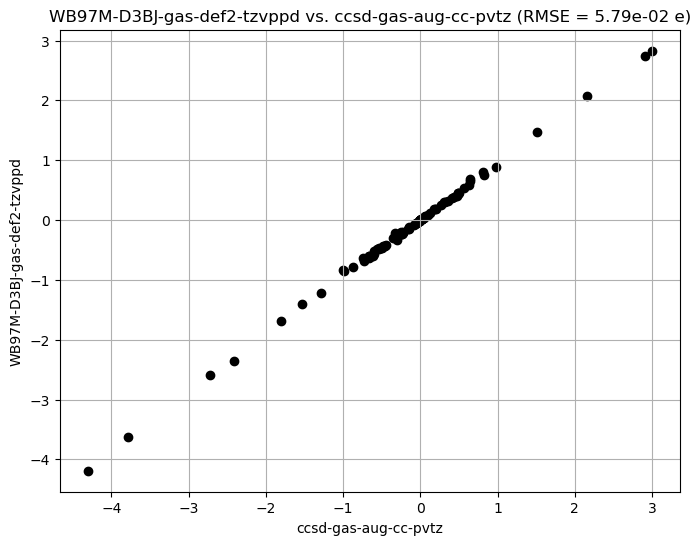

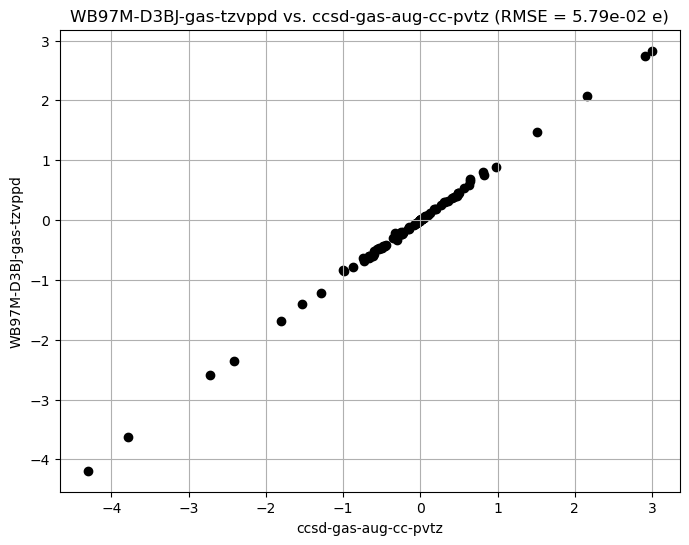

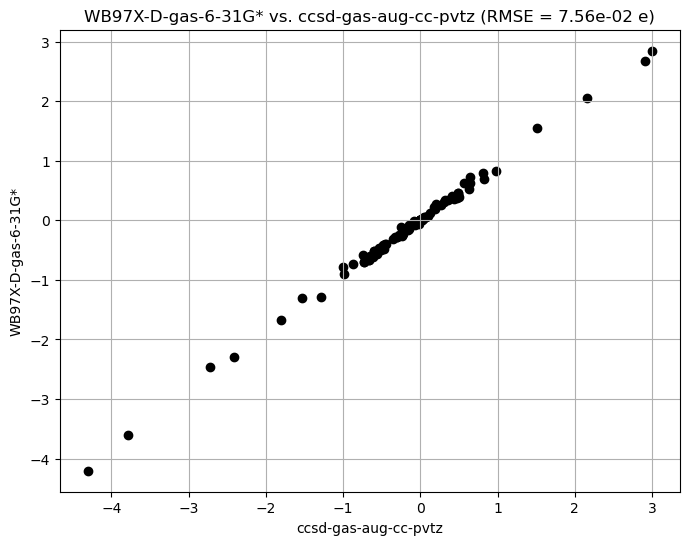

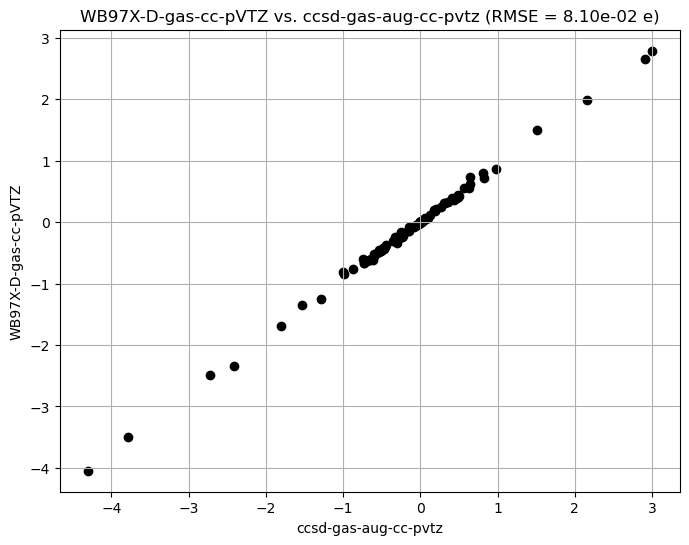

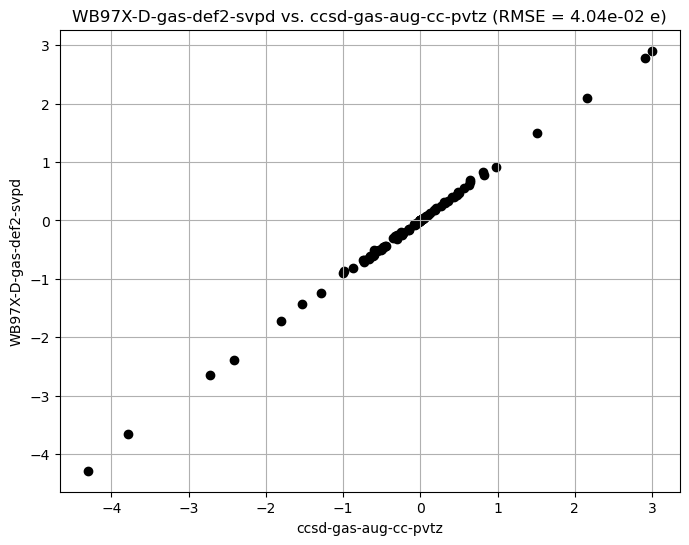

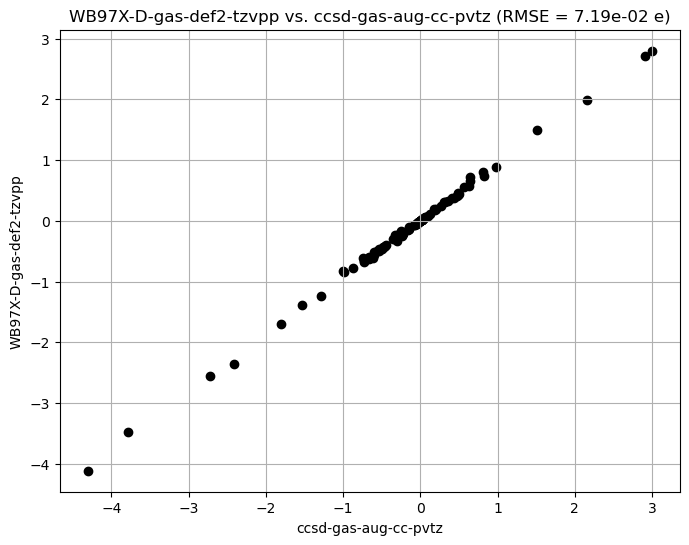

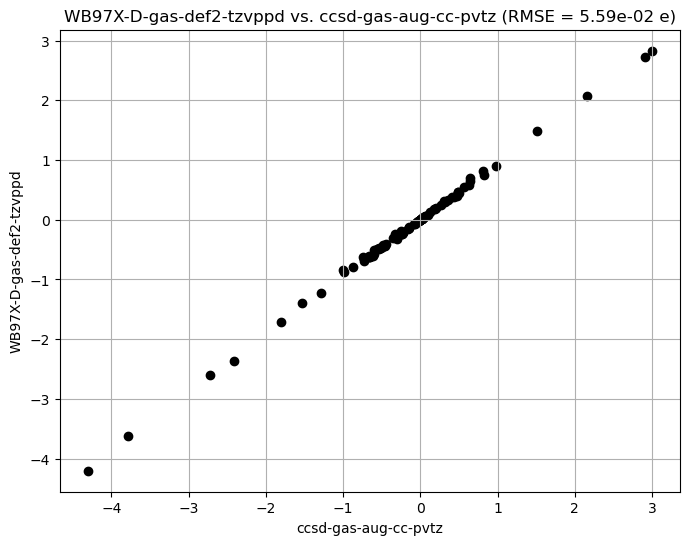

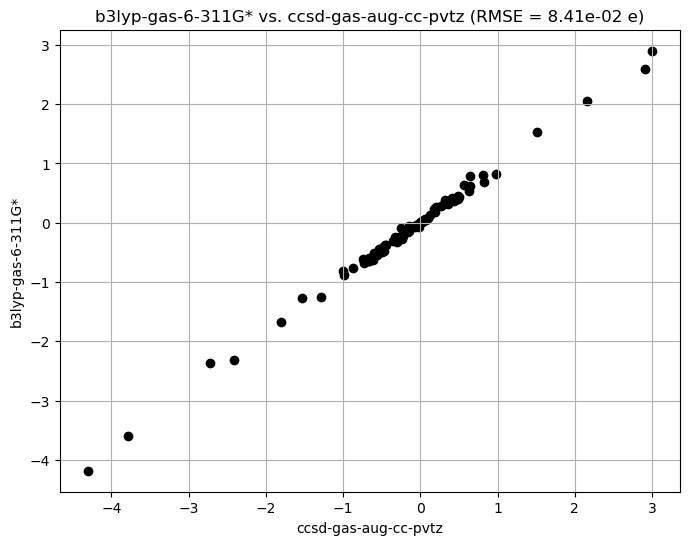

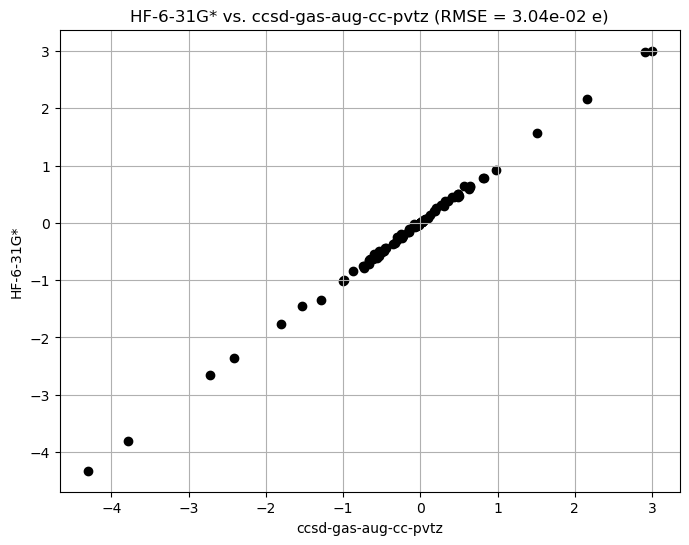

In [53]:
def normalize_dipole(dipole_vector):
    if isinstance(dipole_vector, np.ndarray):  # Check if the value is a list
        return np.linalg.norm(dipole_vector)
    else:
        return None  # Return None or some other flag value for non-list data

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
columns_to_plot = [col for col in pivot_df_dipole.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot.append('HF-6-31G*')

remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

pivot_df_dipole[columns_to_plot].applymap(normalize_dipole)

print(columns_to_plot)
# The target column for comparison
target_column = 'ccsd-gas-aug-cc-pvtz'

rmse_dipoles = []

# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
for col in columns_to_plot:
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    clean_df = pivot_df_dipole[[target_column, col]].dropna()
    pivot_df_filter = pivot_df_dipole.filter(items = [target_column, col])
    col_x = target_column
    x_tot = []
    y_tot = []
    for index, row in pivot_df_filter.iterrows():
        x_values = row[col_x]
        if isinstance(x_values, list):
            # Loop through each specified y-column
            # for col_y, color in col_to_color.items():
                y_values = row[col]
                x_tot.extend(x_values)
                y_tot.extend(y_values)

                # Check if y_values is a list and has the same length as x_values
                if isinstance(y_values, list) and len(x_values) == len(y_values):
                    plt.scatter(x_values, y_values, color='black')  # Use the color assigned to this column
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    information = {"rmse": rmse,
                   "spec": col }
    rmse_dipoles.append(information)

    plt.title(f'{col} vs. {target_column} (RMSE = {rmse:.2e} e)')        
    plt.xlabel(target_column)
    plt.ylabel(col)
    # Plotting details
    plt.grid(True)  # Optional: Add a grid for better readability
    plt.show()

df_rmse_dipoles = pandas.DataFrame(rmse_dipoles)



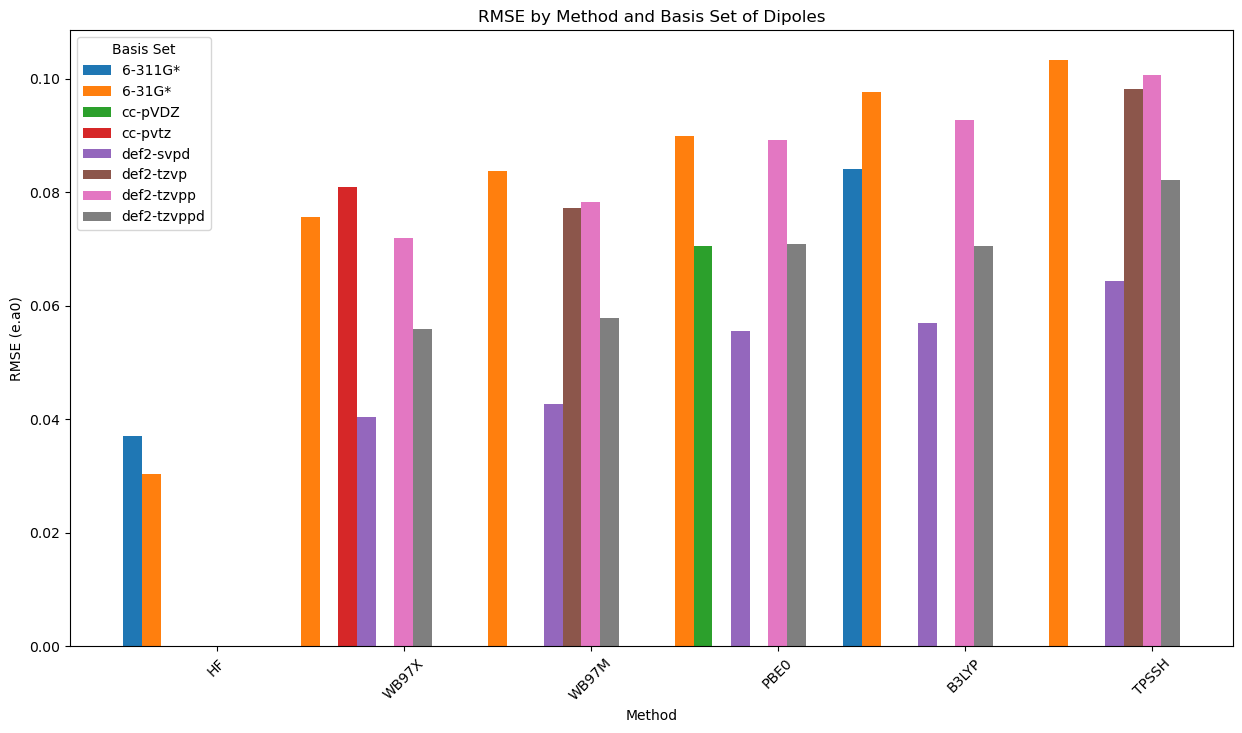

In [54]:
# Create a DataFrame from the list
df_rmse = df_rmse_dipoles


# Extract method and basis from the 'spec' key
df_rmse['method'] = df_rmse['spec'].apply(lambda x: x.split('-')[0].upper())  # Convert method to uppercase for consistency
df_rmse['basis'] = df_rmse['spec'].apply(lambda x: '-'.join(x.split('-')[-2:]))

# Calculate average RMSE for each method to determine the order
average_rmse_by_method = df_rmse.groupby('method')['rmse'].mean().sort_values()

# Sort the dataframe by the average RMSE of each method
df_rmse['method_avg_rmse'] = df_rmse['method'].map(average_rmse_by_method)
df_rmse_sorted = df_rmse.sort_values(by=['method_avg_rmse', 'method', 'basis'])
df_rmse_sorted.drop('method_avg_rmse', axis=1, inplace=True)
# Use a categorical type to ensure the methods are plotted in the sorted order
df_rmse_sorted['method'] = pd.Categorical(df_rmse_sorted['method'], categories=average_rmse_by_method.index, ordered=True)

# Normalize basis set labels
df_rmse_sorted['basis'] = df_rmse_sorted['basis'].replace({
    'cc-pVTZ': 'cc-pvtz',
    'gas-tzvp': 'def2-tzvp',
    'gas-tzvppd': 'def2-tzvppd'
})


# Creating a color map
unique_basis = df_rmse_sorted['basis'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_basis)))
color_map = dict(zip(unique_basis, colors))

# Creating the pivot table
pivot_table = df_rmse_sorted.pivot_table(index='method', columns='basis', values='rmse', aggfunc = 'mean')

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.1  # Adjust as necessary for the number of basis sets
group_width = np.max([np.sum(~pivot_table.loc[method].isna()) for method in pivot_table.index]) * bar_width

# Now, for each basis, we will calculate the exact position
for i, basis in enumerate(pivot_table.columns):
    # Create an offset array which positions each bar in the center of its group
    offsets = np.array([bar_width * (i - np.sum(~pivot_table.loc[method].isna())/2) for method in pivot_table.index])
    # Calculate the actual positions for each bar
    positions = np.arange(len(pivot_table.index)) + offsets
    # Plot the bars
    ax.bar(positions, pivot_table[basis], width=bar_width, label=basis)


# Set the position of the x-axis ticks and labels
ax.set_xticks(np.arange(len(pivot_table)) + bar_width / 2 * (len(pivot_table.columns) - 1))
ax.set_xticklabels(pivot_table.index, rotation=45)

# Adding labels and legend
ax.set_xlabel('Method')
ax.set_ylabel('RMSE (e.a0)')
ax.set_title('RMSE by Method and Basis Set of Dipoles')
ax.legend(title='Basis Set')

plt.show()

In [55]:
esp_db = MoleculePropStore('/mnt/nfs/home/nca121/QCArchive_review/benchmark_review/benchmark.db')
smiles_list = df['molecule'].unique()
df_rmse
# Some methods won't be indexed if we don't change them
df_rmse['method'] = df_rmse['method'].replace({
    'WB97M': 'wb97x-d',
    'WB97X': 'wb97m-d3bj'
})

add_data = []
for mol in smiles_list:
    for row in df_rmse[['method','basis']].iterrows():
        method = row[1]['method']
        basis = row[1]['basis']
        try:
            item =  esp_db.retrieve(smiles=mol,method=method.lower(),basis=basis.lower(), implicit_solvent=None)
            record_data = {
                    "specification": f'gas-{method}-{basis}',
                    "molecule": mol,
                    "basis":basis ,
                    "conformer_geom": item[0].conformer,
                    "dipole": item[0].dipole,
                    "charges": item[0].mbis_charges.flatten(),
                    "mbis dipoles": item[0].mbis_dipole.flatten(),
                    "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                    "esp": item[0].esp_quantity,
                    "grid": item[0].grid_coordinates_quantity,
                }
            add_data.append(record_data)
        except IndexError:
            continue
df_esps = pandas.DataFrame(add_data)

df_esp_all = pd.concat([df_esps,df_ccsd], axis=0)
df_esp_all

specification        molecule         basis  \
0     gas-B3LYP-def2-svpd        c1ccccc1     def2-svpd   
1    gas-B3LYP-def2-tzvpp        c1ccccc1    def2-tzvpp   
2   gas-B3LYP-def2-tzvppd        c1ccccc1   def2-tzvppd   
3      gas-PBE0-def2-svpd        c1ccccc1     def2-svpd   
4     gas-PBE0-def2-tzvpp        c1ccccc1    def2-tzvpp   
..                    ...             ...           ...   
17      ccsd-aug-cc-pVTZP      B(O)(O)OCC  aug-cc-pVTZP   
18      ccsd-aug-cc-pVTZP  CS(=O)(=O)[O-]  aug-cc-pVTZP   
19      ccsd-aug-cc-pVTZP     c1ccc(cc1)O  aug-cc-pVTZP   
20      ccsd-aug-cc-pVTZP         C1CCOC1  aug-cc-pVTZP   
21      ccsd-aug-cc-pVTZP      CC(=O)[O-]  aug-cc-pVTZP   

                                       conformer_geom  \
0   [[0.7974508582830825, -1.1326191568779913, 0.0...   
1   [[0.7974508582830825, -1.1326191568779913, 0.0...   
2   [[0.7974508582830825, -1.1326191568779913, 0.0...   
3   [[0.7974508582830825, -1.1326191568779913, 0.0...   
4   [[0.7974508582830825, -1.1326191568779913, 0.0...   
..                                                ...   
17  [[1.395478760461705, -0.2575718902638816, -0.2...   
18  [[0.8979426107786764, 0.008963642815376621, 0....   
19  [[0.27803172806589543, -1.2408202751965889, -0...   
20  [[0.7137379234091891, -0.7384810326834739, 0.3...   
21  [[-0.6266242364811933, -0.11501855595262243, -...   

                                               dipole  \
0   [6.843413458135217e-08, 1.306422680258379e-06,...   
1   [2.7827012227810144e-07, -8.832203679531858e-0...   
2   [4.6240041640110974e-07, -7.82829667755891e-08...   
3   [-3.757543987070733e-08, 1.4068753593221572e-0...   
4   [1.8634554499463718e-07, 9.617965490704705e-08...   
..                                                ...   
17  [-0.1565040716198567, -0.00852453958799515, 0....   
18  [2.844646740388683, 0.028399159315774414, 0.04...   
19  [-0.14149602998615762, 0.017440759173660947, 0...   
20  [-0.026944096663241712, -0.6861731730010021, 0...   
21  [-2.5930636754485477, -0.43645947942083296, -0...   

                                              charges  \
0   [-0.1294570433761596, -0.1298615652778991, -0....   
1   [-0.13776970381685524, -0.13798438194075238, -...   
2   [-0.13683260460449115, -0.13708865960080202, -...   
3   [-0.14167210015541515, -0.14201974910803228, -...   
4   [-0.149399317260651, -0.1495800595707496, -0.1...   
..                                                ...   
17  [1.368196761676329, -0.976542941462522, -0.948...   
18  [-0.7629871869919886, 1.5451445588776083, -0.7...   
19  [-0.2947536442784639, -0.08196274468052646, -0...   
20  [-0.28584928378780144, -0.28327389073638337, 0...   
21  [-0.7545809540047408, 1.0310936484430953, -0.8...   

                                         mbis dipoles  \
0   [-0.015009606230556256, 0.021146285567506563, ...   
1   [-0.019666552854624614, 0.027822393878357318, ...   
2   [-0.020964199927653977, 0.029602702773790054, ...   
3   [-0.014445774854039915, 0.020330766282438833, ...   
4   [-0.01905596154388372, 0.026957004017926525, -...   
..                                                ...   
17  [-0.003409342799467449, 0.013250815172248938, ...   
18  [0.027127822615364113, 0.00024424033749874234,...   
19  [-0.037194774935808445, -0.01787292124310329, ...   
20  [-0.058812139833100796, 0.014010420293634137, ...   
21  [0.024401811479912303, -0.005326596224233429, ...   

                                     mbis quadrupoles  \
0   [-4.623353871756539, -0.06476828688744118, 0.0...   
1   [-4.63678681034234, -0.06324242939085542, 0.00...   
2   [-4.638559714810438, -0.06335028766646915, 0.0...   
3   [-4.657597808116577, -0.06492582641086724, 0.0...   
4   [-4.672803990072333, -0.06361343537157316, 0.0...   
..                                                ...   
17  [-2.0564888693886245, 0.003491760428842794, 0....   
18  [-6.045731493524617, -0.002643440629861222, -0...   
19  [-4.9729895788255325, -0.03924419840554751, -0

In [64]:
df_esp_all.loc[(df_esp_all['specification']=='gas-wb97x-d-def2-svpd')&(df_esp_all['molecule'].isin(mols))]

specification  molecule      basis  \
9    gas-wb97x-d-def2-svpd  c1ccccc1  def2-svpd   
169  gas-wb97x-d-def2-svpd        CC  def2-svpd   
519  gas-wb97x-d-def2-svpd   C1CCOC1  def2-svpd   

                                        conformer_geom  \
9    [[0.7974508582830825, -1.1326191568779913, 0.0...   
169  [[-0.7628641744518134, 0.007212325544117799, -...   
519  [[0.7137379234091891, -0.7384810326834739, 0.3...   

                                                dipole  \
9    [-1.6603160468697808e-07, 1.7516305188536307e-...   
169  [3.2836116448109465e-07, -3.682493894263672e-0...   
519  [-0.03542705358146181, -0.9184521080281485, 0....   

                                               charges  \
9    [-0.14069913565353412, -0.14106373124319735, -...   
169  [-0.3266654379137502, -0.3266650368742403, 0.1...   
519  [-0.27535038593223965, -0.2730653328200299, 0....   

                                          mbis dipoles  \
9    [-0.013158745769678694, 0.018501537692380075, ...   
169  [0.09200588678320931, -0.0008143580259854712, ...   
519  [-0.054493602955641464, 0.011005776880450856, ...   

                                      mbis quadrupoles  \
9    [-4.647131114596567, -0.06692871284310448, 0.0...   
169  [-4.935918023650008, 0.0010281260463878236, -0...   
519  [-4.769312235808391, -0.007874253822605792, -0...   

                                                   esp  \
9    [[0.006926002357631411 hartree / elementary_ch...   
169  [[-0.0012367820184815415 hartree / elementary_...   
519  [[0.005175868022305075 hartree / elementary_ch...   

                                                  grid  
9    [[-4.596194077712559 angstrom, -1.060660171338...  
169  [[-3.889087296526011 angstrom, -1.060660171779...  
519  [[-4.242640687119285 angstrom, -0.353553390186...

In [63]:
df_wbtest

specification   molecule      basis  \
0  WB97X-D-gas-def2-svpd   c1ccccc1  def2-svpd   
1  WB97X-D-gas-def2-svpd         CC  def2-svpd   
2  WB97X-D-gas-def2-svpd  Oc1ccccc1  def2-svpd   
3  WB97X-D-gas-def2-svpd    C1CCOC1  def2-svpd   

                                      conformer_geom  \
0  [[0.7974508582830825, -1.1326191568779913, 0.0...   
1  [[-0.7628641744518134, 0.007212325544117799, -...   
2  [[0.27803172806589543, -1.2408202751965889, -0...   
3  [[0.7137379234091891, -0.7384810326834739, 0.3...   

                                              dipole  \
0  [5.1004833023782226e-08, 3.564589867721679e-07...   
1  [-8.676989970979321e-08, -9.890622321151454e-0...   
2  [-0.14953491556490306, 0.018443436300302096, 0...   
3  [-0.02814251620298558, -0.7111501687934982, 0....   

                                        mbis charges  \
0  [-0.12769475193817195, -0.12764923941307355, -...   
1  [-0.32276085949836353, -0.32276087994672914, 0...   
2  [-0.28516948699474703, -0.08026337546964545, -...   
3  [-0.278178676195254, -0.27538845220094976, 0.1...   

                                        mbis dipoles  \
0  [-0.013191994138057866, 0.018761679413125062, ...   
1  [0.08873535481442853, -0.0008355937460688183, ...   
2  [-0.034814609004978424, -0.02324116291338569, ...   
3  [-0.055252064022770726, 0.009827741222084959, ...   

                                    mbis quadrupoles  \
0  [-4.623187964277183, -0.0686477887376345, 0.00...   
1  [-4.925546983546715, 0.0011237346788940436, -0...   
2  [-4.918561353106382, -0.041594651925840956, -0...   
3  [-4.792001197374316, -0.009813674153731862, -0...   

                                                 esp  \
0  [[0.006231644 hartree / elementary_charge], [0...   
1  [[-0.0011385102 hartree / elementary_charge], ...   
2  [[0.0065101344 hartree / elementary_charge], [...   
3  [[0.0041116691 hartree / elementary_charge], [...   

                                                grid  
0  [[-4.596194077712559 angstrom, -1.060660171338...  
1  [[-3.889087296526011 angstrom, -1.060660171779...  
2  [[-4.9497474678987725 angstrom, -0.35355339059...  
3  [[-4.242640687119285 angstrom, -0.353553390186...

In [90]:
df_hf

specification   molecule      basis  \
0  HF-def2-svpd   c1ccccc1  def2-svpd   
1  HF-def2-svpd         CC  def2-svpd   
2  HF-def2-svpd  Oc1ccccc1  def2-svpd   
3  HF-def2-svpd    C1CCOC1  def2-svpd   

                                      conformer_geom  \
0  [[0.7974508582830825, -1.1326191568779913, 0.0...   
1  [[-0.7628641744518134, 0.007212325544117799, -...   
2  [[0.27803172806589543, -1.2408202751965889, -0...   
3  [[0.7137379234091891, -0.7384810326834739, 0.3...   

                                              dipole  \
0  [7.370337895551415e-08, 7.822263059509282e-08,...   
1  [-4.126093244849471e-09, -5.066169461720449e-0...   
2  [-0.17854713659043142, 0.021836597785720446, 0...   
3  [-0.030832415280443115, -0.749124814189603, 0....   

                                        mbis charges  \
0  [-0.12794254666730454, -0.12784268649355807, -...   
1  [-0.26995352666944045, -0.2699535135021334, 0....   
2  [-0.30537701365617287, -0.0665229425623515, -0...   
3  [-0.2535346752120315, -0.25159159058084507, 0....   

                                        mbis dipoles  \
0  [-0.006949433477654892, 0.009934003707419339, ...   
1  [0.07484542797234799, -0.0007037351076461509, ...   
2  [-0.02879301468892997, -0.03894970037910036, -...   
3  [-0.05024228620940663, -0.003136493729573263, ...   

                                    mbis quadrupoles  \
0  [-4.729955620047754, -0.0729798642194684, 0.00...   
1  [-4.901351190665118, 0.001248403656851958, -0....   
2  [-5.0440849792821325, -0.0491732080145968, -0....   
3  [-4.8046526074417235, -0.014108022876521489, -...   

                                                 esp  \
0  [[0.0067489341 hartree / elementary_charge], [...   
1  [[-0.0011539527 hartree / elementary_charge], ...   
2  [[0.007090604 hartree / elementary_charge], [0...   
3  [[0.0045771828 hartree / elementary_charge], [...   

                                                grid  
0  [[-4.596194077712559 angstrom, -1.060660171338...  
1  [[-3.889087296526011 angstrom, -1.060660171779...  
2  [[-4.9497474678987725 angstrom, -0.35355339059...  
3  [[-4.242640687119285 angstrom, -0.353553390186...

In [80]:
HA_TO_KCAL_P_MOL = 627.509391  # Hartrees to kilocalories per mole

#compare WB97X rebuilt ESP (df_esp_all) with ESP built in charge craft
(((df_esp_all[(df_esp_all['molecule'] == 'C1CCOC1') & (df_esp_all['specification']=='gas-wb97x-d-def2-svpd')]['esp'].item() - df_wbtest[df_wbtest['molecule'] == 'C1CCOC1']['esp'].item())**2).mean()**0.5)*HA_TO_KCAL_P_MOL


1.591819910950409 <Unit('hartree / elementary_charge')>

In [91]:
#compare WB97X rebuilt ESP to ESP in chargecraft
(((df_esp_all[(df_esp_all['molecule'] == 'C1CCOC1') & (df_esp_all['specification']=='gas-wb97x-d-def2-svpd')]['esp'].item() - df_hf[df_hf['molecule'] == 'C1CCOC1']['esp'].item())**2).mean()**0.5)*HA_TO_KCAL_P_MOL

1.2565583215404388 <Unit('hartree / elementary_charge')>

In [58]:
df_esp_all['specification'].unique()

array(['gas-B3LYP-def2-svpd', 'gas-B3LYP-def2-tzvpp',
       'gas-B3LYP-def2-tzvppd', 'gas-PBE0-def2-svpd',
       'gas-PBE0-def2-tzvpp', 'gas-PBE0-def2-tzvppd',
       'gas-TPSSH-def2-svpd', 'gas-TPSSH-def2-tzvpp',
       'gas-TPSSH-def2-tzvppd', 'gas-wb97x-d-def2-svpd',
       'gas-wb97x-d-def2-tzvpp', 'gas-wb97x-d-def2-tzvppd',
       'gas-wb97m-d3bj-def2-svpd', 'gas-wb97m-d3bj-def2-tzvpp',
       'gas-wb97m-d3bj-def2-tzvppd', 'gas-HF-6-31G*', 'ccsd-aug-cc-pVTZP'],
      dtype=object)

In [ ]:
esp_db.retrieve(method='wb97x-d')

[MoleculePropRecord(tagged_smiles='[c:1]1([H:8])[c:2]([H:9])[c:3]([H:10])[c:4]([I:7])[c:5]([H:11])[c:6]1[H:12]', conformer=array([[-1.46612071,  0.07304853,  0.03713677],
        [-0.8333307 , -1.15487771,  0.02203017],
        [ 0.54680124, -1.22950853, -0.01292404],
        [ 1.28856635, -0.06418917, -0.03263941],
        [ 0.6662434 ,  1.16913686, -0.01780252],
        [-0.7144691 ,  1.23196717,  0.0171755 ],
        [ 3.38140194, -0.16858675, -0.08565029],
        [-2.53725968,  0.12644217,  0.06426871],
        [-1.41023536, -2.05953475,  0.03736246],
        [ 1.03261737, -2.18425681, -0.02451266],
        [ 1.24447157,  2.07086602, -0.0331661 ],
        [-1.19868631,  2.18949298,  0.02872143]]), grid_coordinates=array([[-4.59619408e+00, -1.06066017e+00,  4.40981009e-10],
        [-4.59619408e+00, -1.06066017e+00,  7.07106782e-01],
        [-4.59619408e+00, -7.07106781e-01, -3.53553390e-01],
        ...,
        [ 6.36396103e+00,  2.12132034e+00, -7.07106781e-01],
        [ 6.363

In [ ]:
df_rmse

rmse                        spec      method        basis  \
0   0.057024         B3LYP-gas-def2-svpd       B3LYP    def2-svpd   
1   0.092725        B3LYP-gas-def2-tzvpp       B3LYP   def2-tzvpp   
2   0.070545       B3LYP-gas-def2-tzvppd       B3LYP  def2-tzvppd   
3   0.037044              HF-gas-6-311G*          HF      6-311G*   
4   0.070539        PBE0-gas-aug-cc-pVDZ        PBE0      cc-pVDZ   
5   0.055583          PBE0-gas-def2-svpd        PBE0    def2-svpd   
6   0.089224         PBE0-gas-def2-tzvpp        PBE0   def2-tzvpp   
7   0.070827        PBE0-gas-def2-tzvppd        PBE0  def2-tzvppd   
8   0.064336         TPSSH-gas-def2-svpd       TPSSH    def2-svpd   
9   0.100638        TPSSH-gas-def2-tzvpp       TPSSH   def2-tzvpp   
10  0.082123       TPSSH-gas-def2-tzvppd       TPSSH  def2-tzvppd   
11  0.098272              TPSSH-gas-tzvp       TPSSH     gas-tzvp   
12  0.042693    WB97M-D3BJ-gas-def2-svpd     wb97x-d    def2-svpd   
13  0.077222    WB97M-D3BJ-gas-def2-tzvp     wb97x-d    def2-tzvp   
14  0.078209   WB97M-D3BJ-gas-def2-tzvpp     wb97x-d   def2-tzvpp   
15  0.057856  WB97M-D3BJ-gas-def2-tzvppd     wb97x-d  def2-tzvppd   
16  0.057862       WB97M-D3BJ-gas-tzvppd     wb97x-d   gas-tzvppd   
17  0.080966         WB97X-D-gas-cc-pVTZ  wb97m-d3bj      cc-pVTZ   
18  0.040352       WB97X-D-gas-def2-svpd  wb97m-d3bj    def2-svpd   
19  0.071911      WB97X-D-gas-def2-tzvpp  wb97m-d3bj   def2-tzvpp   
20  0.055887     WB97X-D-gas-def2-tzvppd  wb97m-d3bj  def2-tzvppd   
21  0.084113           b3lyp-gas-6-311G*       B3LYP      6-311G*   
22  0.030375                   HF-6-31G*          HF       6-31G*   

    method_avg_rmse  
0          0.076102  
1          0.076102  
2          0.076102  
3          0.033710  
4          0.071543  
5          0.071543  
6          0.071543  
7          0.071543  
8          0.086342  
9          0.086342  
10         0.086342  
11         0.086342  
12         0.062768  
13         0.062768  
14         0.062768  
15         0.062768  
16         0.062768  
17         0.062279  
18         0.062279  
19         0.062279  
20         0.062279  
21         0.076102  
22         0.033710

In [ ]:
df_prepared_esp = df_esp_all[['specification','molecule','basis','dipole','charges','esp']]

pivot_df_esp = df_prepared_esp.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='esp',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()
pivot_df_esp

specification           molecule  \
0                     B(O)(O)OCC   
1                    C1=CNC=C1Br   
2                      C1=CSC=C1   
3                  C1=CSN=C1[O-]   
4                  C1=C[NH+]=CN1   
5                    C1CC(=O)NC1   
6                        C1CCNC1   
7                        C1CCOC1   
8                  C1CC[NH2+]CC1   
9                             CC   
10                       CC(=O)C   
11                       CC(=O)O   
12                    CC(=O)[O-]   
13                        CC(C)F   
14               CC1=CNc2c1cccc2   
15                           CCO   
16                           CCS   
17                          CCSC   
18                           COC   
19                   COCC(F)(F)F   
20                 CO[Si](C)(C)O   
21              CP(=O)([O-])[O-]   
22                CS(=O)(=O)[O-]   
23                C[Si]1(CCCC1)C   
24              [B-](COC)(F)(F)F   
25             c1cc(c(c(c1)F)F)F   
26                  c1cc(cnc1)Cl   
27                  c1ccc(cc1)Br   
28                 c1ccc(cc1)C#N   
29                  c1ccc(cc1)Cl   
30                   c1ccc(cc1)F   
31                   c1ccc(cc1)I   
32                   c1ccc(cc1)N   
33                   c1ccc(cc1)O   
34                c1ccc(cc1)[S-]   
35                      c1ccccc1   

specification                                  ccsd-aug-cc-pVTZP  \
0                                                            NaN   
1                                                            NaN   
2              [[0.0086486392 hartree / elementary_charge], [...   
3                                                            NaN   
4                                                            NaN   
5              [[0.0102268697 hartree / elementary_charge], [...   
6                                                            NaN   
7              [[0.0039441317 hartree / elementary_charge], [...   
8                                                            NaN   
9              [[-0.0012006692 hartree / elementary_charge], ...   
10             [[0.0041399827 hartree / elementary_charge], [...   
11             [[0.0071485092 hartree / elementary_charge], [...   
12                                                           NaN   
13             [[0.0018394519 hartree / elementary_charge], [...   
14                                                           NaN   
15             [[0.0028556834 hartree / elementary_charge], [...   
16                                                           NaN   
17                                                           NaN   
18             [[0.0042622292 hartree / elementary_charge], [...   
19             [[0.0094392082 hartree / elementary_charge], [...   
20                                                           NaN   
21                                                           NaN   
22             [[-0.1521779707 hartree / elementary_charge], ...   
23                                                           NaN   
24             [[-0.0861502925 hartree / elementary_charge], ...   
25                                                           NaN   
26                                                           NaN   
27                                                           NaN   
28                                                           NaN   
29             [[0.0099723937 hartree / elementary_charge], [...   
30             [[-0.0101883943 hartree / elementary_charge], ...   
31                                                           NaN   
32                                                           NaN   
33             [[0.0065878062 hartree / elementary_charge], [...   
34                                                           NaN   
35             [[0.0063854267 hartree / elementary_charge], [...   

specification                                gas-B3LYP-def2-svpd  \
0              [[0.0016757568774119491 hartree / elementary_c...   
1             

In [ ]:
pivot_df_esp.to_csv('esp_csv.csv')

In [ ]:
pivot_df_esp['ccsd-aug-cc-pVTZP'].iloc[2]

array([[0.00864864],
       [0.00834538],
       [0.00938734],
       ...,
       [0.00951231],
       [0.00918525],
       [0.00920439]]) <Unit('hartree / elementary_charge')>

In [ ]:
from openff.units import unit

HA_TO_KCAL_P_MOL = 627.509391  # Hartrees to kilocalories per mole

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
columns_to_plot = [col for col in pivot_df_esp.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
# columns_to_plot.append('HF-6-31G*')
print(columns_to_plot)

remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

# print(columns_to_plot)
# The target column for comparison
target_column = 'ccsd-aug-cc-pVTZP'

rmses = []
# df_rmse = pd.DataFrame(['spec','rmse'])
# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
#something wrong with boron results
pivot_df_esp['molecule']
molecule_rmses = []
for col in columns_to_plot:
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    clean_df = pivot_df_esp[[target_column, col, 'molecule']].dropna()
    pivot_df_filter = pivot_df_esp.filter(items = [target_column, col, 'molecule'])
    pivot_df_wall_time_filter = pivot_df_wall_time.filter(items = [col])
    col_x = target_column
    x_tot = []
    y_tot = []
    w_time_tot = []
    for (index, row), (index_wt, row_wt) in zip(pivot_df_filter.iterrows(), pivot_df_wall_time_filter.iterrows()):
        x_values = row[col_x]
        if isinstance(x_values, unit.Quantity):
                x_values = x_values.m.flatten().tolist()
                y_values = row[col].m.flatten().tolist()
                rmse_esp_mol = ((((np.array(x_values) - np.array(y_values))**2).mean()**0.5)*HA_TO_KCAL_P_MOL)
                if rmse_esp_mol > 10:
                     print(f"excluding {row['molecule']}")
                     continue
                # print(x_values)
                x_tot.extend(x_values)
                y_tot.extend(y_values)
                # if 'ccsd' not in col:
                #   w_time_tot.append(row_wt[col])
                # # Check if y_values is a list and has the same length as x_values
                # if isinstance(y_values, list) and len(x_values) == len(y_values):
                #     plt.scatter(x_values, y_values, color='black')  # Use the color assigned to this column
                #     rmse_molecule = np.sqrt(mean_squared_error(y_values, x_values))
                #     information_molecule = {"molecule":clean_df['molecule'][index],
                #                 "spec": spec,
                #                 "rmse": rmse_molecule
                #                 }
                #     molecule_rmses.append(information_molecule)
    # print(len(x_tot))
    if len(x_tot) == 0:
         continue
    # print(x_tot)
    # print(y_tot)
    rmse_esp = ((((np.array(x_tot) - np.array(y_tot))**2).mean()**0.5)*HA_TO_KCAL_P_MOL)
    # rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    wall_tm_mean = np.mean(w_time_tot)
    information = {"rmse": rmse_esp,
                   "spec": col,
                   "wall time": wall_tm_mean}
    

    rmses.append(information)

    # plt.title(f'{col} vs. {target_column} (RMSE = {rmse:.2e} e)')        
    # plt.xlabel(target_column)
    # plt.ylabel(col)
    # # Plotting details
    # plt.grid(True)  # Optional: Add a grid for better readability
    # plt.show()
df_dft_rmse_esp = pandas.DataFrame(rmses)
# df_molecules_rmse_esp  = pandas.DataFrame(molecule_rmses)
df_dft_rmse_esp

['gas-B3LYP-def2-svpd', 'gas-B3LYP-def2-tzvpp', 'gas-B3LYP-def2-tzvppd', 'gas-HF-6-31G*', 'gas-PBE0-def2-svpd', 'gas-PBE0-def2-tzvpp', 'gas-PBE0-def2-tzvppd', 'gas-TPSSH-def2-svpd', 'gas-TPSSH-def2-tzvpp', 'gas-TPSSH-def2-tzvppd', 'gas-wb97m-d3bj-def2-svpd', 'gas-wb97m-d3bj-def2-tzvpp', 'gas-wb97m-d3bj-def2-tzvppd', 'gas-wb97x-d-def2-svpd', 'gas-wb97x-d-def2-tzvpp', 'gas-wb97x-d-def2-tzvppd']
ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz
excluding C1=CSC=C1
excluding CS(=O)(=O)[O-]
excluding [B-](COC)(F)(F)F
excluding C1=CSC=C1
excluding CS(=O)(=O)[O-]
excluding [B-](COC)(F)(F)F
excluding C1=CSC=C1
excluding CS(=O)(=O)[O-]
excluding [B-](COC)(F)(F)F


/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/hom

excluding CS(=O)(=O)[O-]


/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/hom

rmse                        spec  wall time
0   2.042685         gas-B3LYP-def2-svpd        NaN
1   1.631232        gas-B3LYP-def2-tzvpp        NaN
2   1.524896       gas-B3LYP-def2-tzvppd        NaN
3   0.817062               gas-HF-6-31G*        NaN
4   2.021227          gas-PBE0-def2-svpd        NaN
5   1.643444         gas-PBE0-def2-tzvpp        NaN
6   1.664807        gas-PBE0-def2-tzvppd        NaN
7   1.914441         gas-TPSSH-def2-svpd        NaN
8   1.510470        gas-TPSSH-def2-tzvpp        NaN
9   1.385923       gas-TPSSH-def2-tzvppd        NaN
10  2.099107    gas-wb97m-d3bj-def2-svpd        NaN
11  1.659422   gas-wb97m-d3bj-def2-tzvpp        NaN
12  1.637930  gas-wb97m-d3bj-def2-tzvppd        NaN
13  2.157193       gas-wb97x-d-def2-svpd        NaN
14  1.747169      gas-wb97x-d-def2-tzvpp        NaN
15  1.728807     gas-wb97x-d-def2-tzvppd        NaN

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
df_dft_rmse_esp.sort_values('rmse')

rmse                        spec  wall time
3   0.817062               gas-HF-6-31G*        NaN
9   1.385923       gas-TPSSH-def2-tzvppd        NaN
8   1.510470        gas-TPSSH-def2-tzvpp        NaN
2   1.524896       gas-B3LYP-def2-tzvppd        NaN
1   1.631232        gas-B3LYP-def2-tzvpp        NaN
12  1.637930  gas-wb97m-d3bj-def2-tzvppd        NaN
5   1.643444         gas-PBE0-def2-tzvpp        NaN
11  1.659422   gas-wb97m-d3bj-def2-tzvpp        NaN
6   1.664807        gas-PBE0-def2-tzvppd        NaN
15  1.728807     gas-wb97x-d-def2-tzvppd        NaN
14  1.747169      gas-wb97x-d-def2-tzvpp        NaN
7   1.914441         gas-TPSSH-def2-svpd        NaN
4   2.021227          gas-PBE0-def2-svpd        NaN
0   2.042685         gas-B3LYP-def2-svpd        NaN
10  2.099107    gas-wb97m-d3bj-def2-svpd        NaN
13  2.157193       gas-wb97x-d-def2-svpd        NaN

In [ ]:
esp_db.retrieve(smiles='CCO',method='b3lyp', basis='def2-tzvppd')

[MoleculePropRecord(tagged_smiles='[C:1]([C:2]([O:3][H:9])([H:7])[H:8])([H:4])([H:5])[H:6]', conformer=array([[-0.9186198 ,  0.06840562,  0.0601357 ],
        [ 0.50832554, -0.41589639, -0.13645246],
        [ 1.44631976,  0.39778409,  0.51543623],
        [-1.06010443,  1.05642133, -0.37116226],
        [-1.62616598, -0.60309467, -0.41671228],
        [-1.15700232,  0.12715035,  1.116056  ],
        [ 0.73901195, -0.48796336, -1.19789946],
        [ 0.63178215, -1.40345774,  0.28728931],
        [ 1.43645313,  1.26065078,  0.14330923]]), grid_coordinates=array([[-4.24264069e+00, -3.53553391e-01,  1.23358114e-17],
        [-4.24264069e+00,  0.00000000e+00, -3.53553391e-01],
        [-4.24264069e+00,  0.00000000e+00,  3.53553391e-01],
        ...,
        [ 4.24264069e+00,  1.06066017e+00,  1.41421356e+00],
        [ 4.24264069e+00,  1.41421356e+00,  3.53553391e-01],
        [ 4.24264069e+00,  1.41421356e+00,  1.06066017e+00]]), esp=array([[ 0.00370135],
        [ 0.00393874],
        [